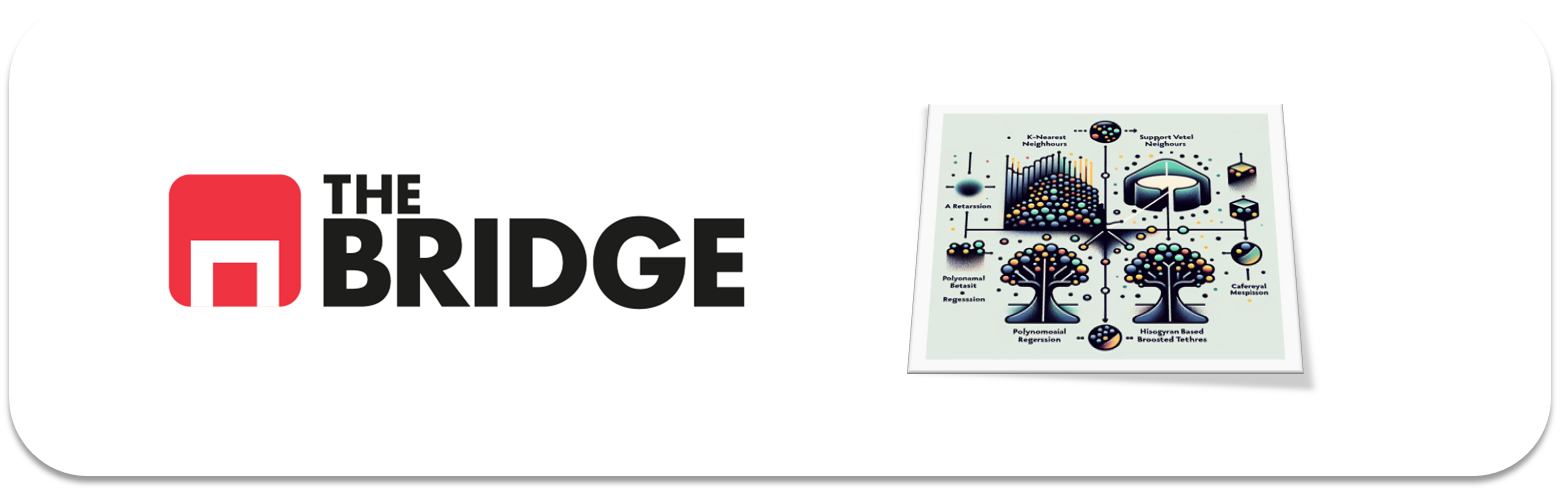

# PRÁCTICA OBLIGATORIA
## **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns


plt.style.use("dark_background")

### El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio.


#### `Give me some credit`
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df_credit = pd.read_csv("./data/credit_npo.csv")
df_credit.head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 0                              0.081892   37   
1                 0                              0.023413   74   
2                 0                              0.000000   43   
3                 0                              0.492754   44   
4                 0                              1.000000   63   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     0   0.070709         5656.0   
1                                     0   0.209197         4870.0   
2                                     0   0.080784         5000.0   
3                                     0   0.412735         7333.0   
4                                     0   0.000000         8333.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               12                        1   
1                                9                        0   
2                                2                        0   
3                                4                        0   
4                                3                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             0                                     0   
1                             1                                     0   
2                             0                                     0   
3                             2                                     0   
4                             0                                     0   

   NumberOfDependents  
0                 0.0  
1                 0.0  
2                 2.0  
3                 3.0  
4                 1.0

In [3]:
df_credit.shape
print("Registros:", df_credit.shape[0])
print("Columnas:", df_credit.shape[1])

Registros: 12537
Columnas: 11


In [4]:
df_credit.info()

<class 'pandas.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), int64(7)
me

In [5]:
def get_quality(dataframe: pd.DataFrame) -> pd.DataFrame:
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])

	return data.T

In [6]:
get_quality(df_credit)

Cardinality  Uniqueness   Null
SeriousDlqin2yrs                              2.0    0.000160    0.0
RevolvingUtilizationOfUnsecuredLines      10764.0    0.858579    0.0
age                                          78.0    0.006222    0.0
NumberOfTime30-59DaysPastDueNotWorse         10.0    0.000798    0.0
DebtRatio                                 11547.0    0.921034    0.0
MonthlyIncome                              4167.0    0.332376  721.0
NumberOfOpenCreditLinesAndLoans              43.0    0.003430    0.0
NumberOfTimes90DaysLate                      13.0    0.001037    0.0
NumberRealEstateLoansOrLines                 16.0    0.001276    0.0
NumberOfTime60-89DaysPastDueNotWorse          8.0    0.000638    0.0
NumberOfDependents                           10.0    0.000798  177.0

### Análisis

Como vemos hay varios nulos en dos columnas: `MonthlyIncome` y `NumberOfDependents`.

In [7]:
df_credit.describe().T

count         mean           std  \
SeriousDlqin2yrs                      12537.0     0.068916      0.253321   
RevolvingUtilizationOfUnsecuredLines  12537.0     0.330359      0.368148   
age                                   12537.0    52.079445     15.077498   
NumberOfTime30-59DaysPastDueNotWorse  12537.0     0.409588      4.055787   
DebtRatio                             12537.0     1.902253      9.122216   
MonthlyIncome                         11816.0  6864.815420  11855.905437   
NumberOfOpenCreditLinesAndLoans       12537.0     8.482332      5.165422   
NumberOfTimes90DaysLate               12537.0     0.259312      4.035658   
NumberRealEstateLoansOrLines          12537.0     0.999202      1.134325   
NumberOfTime60-89DaysPastDueNotWorse  12537.0     0.228364      4.018873   
NumberOfDependents                    12360.0     0.822087      1.136802   

                                       min          25%          50%  \
SeriousDlqin2yrs                       0.0     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines   0.0     0.030651     0.163490   
age                                   21.0    41.000000    51.000000   
NumberOfTime30-59DaysPastDueNotWorse   0.0     0.000000     0.000000   
DebtRatio                              0.0     0.142268     0.302025   
MonthlyIncome                          0.0  3498.750000  5416.000000   
NumberOfOpenCreditLinesAndLoans        0.0     5.000000     8.000000   
NumberOfTimes90DaysLate                0.0     0.000000     0.000000   
NumberRealEstateLoansOrLines           0.0     0.000000     1.000000   
NumberOfTime60-89DaysPastDueNotWorse   0.0     0.000000     0.000000   
NumberOfDependents                     0.0     0.000000     0.000000   

                                              75%       max  
SeriousDlqin2yrs                         0.000000       1.0  
RevolvingUtilizationOfUnsecuredLines     0.582219       6.0  
age                                     62.000000     101.0  
NumberOfTime30-59DaysPastDueNotWorse     0.000000      98.0  
DebtRatio                                0.506725      99.0  
MonthlyIncome                         8300.000000  702500.0  
NumberOfOpenCreditLinesAndLoans         11.000000      49.0  
NumberOfTimes90DaysLate                  0.000000      98.0  
NumberRealEstateLoansOrLines             2.000000      19.0  
NumberOfTime60-89DaysPastDueNotWorse     0.000000      98.0  
NumberOfDependents                       1.000000      10.0

Como podemos visualizar, tenemos algunas columnas con `outliers`.

Revisamos los duplicados

In [8]:
mask = df_credit.duplicated(keep=False)
df_credit.loc[mask, :].sort_values(by="age")

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
66                    0                                   1.0   22   
7135                  0                                   0.0   22   
12026                 0                                   0.0   22   
11445                 0                                   1.0   22   
2225                  0                                   1.0   24   
237                   0                                   1.0   24   
3562                  0                                   1.0   27   
11970                 0                                   1.0   27   
723                   0                                   1.0   40   
1768                  0                                   1.0   40   
7693                  0                                   1.0   43   
5921                  0                                   1.0   43   
4402                  0                                   1.0   50   
11718                 0                                   1.0   50   
7330                  0                                   1.0   52   
5276                  0                                   1.0   52   
2903                  0                                   1.0   54   
3602                  0                                   1.0   54   
3810                  0                                   0.0   56   
9732                  0                                   0.0   56   
9865                  0                                   0.0   61   
5384                  0                                   0.0   61   
5083                  0                                   0.0   81   
8618                  0                                   0.0   81   
7470                  0                                   0.0   81   
7383                  0                                   0.0   81   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
66                                        0        0.0            NaN   
7135                                      0        0.0          820.0   
12026                                     0        0.0          820.0   
11445                                     0        0.0            NaN   
2225                                      0        0.0            NaN   
237                                       0        0.0            NaN   
3562                                      0        0.0            NaN   
11970                                     0        0.0            NaN   
723                                       0        0.0            NaN   
1768                                      0        0.0            NaN   
7693                                      0        0.0            NaN   
5921                                      0        0.0            NaN   
4402                                      0        0.0            NaN   
11718                                     0        0.0            NaN   
7330                                      0        0.0            NaN   
5276                                      0        0.0            NaN   
2903                                      0        0.0            NaN   
3602                                      0        0.0            NaN   
3810                                      0        0.0            NaN   
9732                                      0        0.0            NaN   
9865                                      0        0.0            NaN   
5384                                      0        0.0            NaN   
5083                                      0        0.0            NaN   
8618                                      0        0.0            NaN   
7470                                      0        0.0            NaN   
7383                                      0        0.0            NaN   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
66                                   0                        0   
7135      

#### Interpretación de las columnas

> 1. `SeriousDlqin2yrs` (**binaria**): morosidad grave en los posteriores dos años a la adquisición del crédito
>
> 2. `RevolvingUtilizationOfUnsecuredLines` (**numérica continua**): uso del crédito rotativo no garantizado
>
> 3. `age` (**numérica discreta**): edad del cliente.
>
> 4. `DebtRatio` (**numérica continua**): deuda total según ingresos
>
> 5. `MonthlyIncome` (**numérica continua**): ingreso mensual
>
> 6. `NumberOfOpenCreditLinesAndLoans` (**numérica discreta**): total de prestamos y créditos vigentes
>
> 7. `NumberRealEstateLoansOrLines` (**numérica discreta**): cantidad de prestamos, líneas de crédito relacionados a vivienda
>
> 8. `NumberOfTime30-59DaysPastDueNotWorse` (**numérica discreta**): cantidad de veces que estuvo atrasado entre 30 y 59 días
>
> 9. `NumberOfTime60-89DaysPastDueNotWorse` (**numérica discreta**): cantidad de veces que estuvo atrasado entre 60 y 89 días
>
> 10. `NumberOfTimes90DaysLate` (**numérica discreta**): cantidad de veces que estuvo atrasado más de 90 días
>
> 11. `NumberOfDependents` (**numérica discreta**): personas a cargo

#### Conociendo el problema
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Es un problema de clasificación binaria. La variable target es `SeriousDlqin2yrs`.

#### Distribución de target
Pinta la distribución de frecuencias del target y coméntala

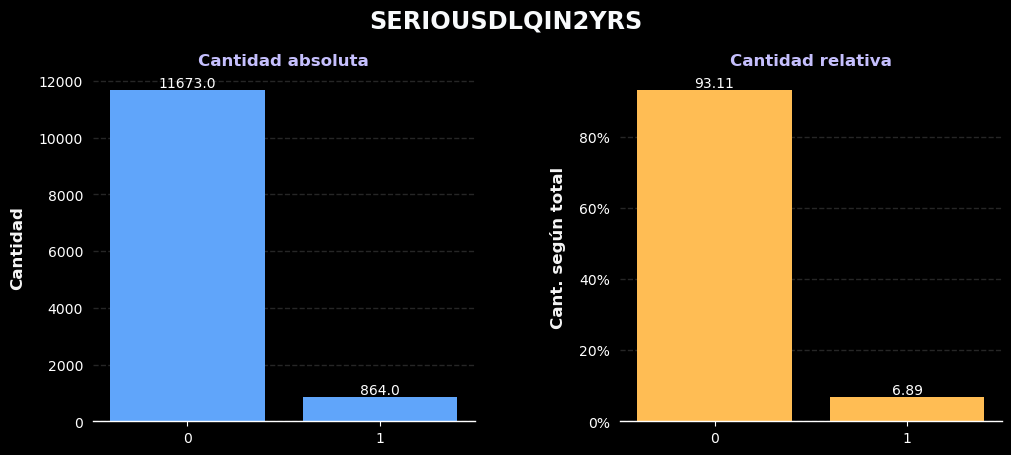

In [9]:
from matplotlib import ticker


serie = df_credit["SeriousDlqin2yrs"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	f"{serie.name}".upper(),
	color="#F8FAFC",
	fontproperties=font_config,
	y=1.10
)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
bar_container = axs[0].bar(
	x=data.index,
	height=data.values,
	data=data,
	color="#60A5FA",
	zorder=2
)
axs[0].bar_label(bar_container, fmt=lambda x: f"{x:.1f}")

font_config = {
	"color": "#F5F5F5",
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="y", width=0)
axs[0].set_xticks(ticks=data.index)

axs[0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0].grid(
	axis="y",
	alpha=1,
	color="#262626",
	linestyle="dashed",
	linewidth=1
)
axs[0].spines[["left", "top", "right"]].set_visible(False)
axs[0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
rect = axs[1].bar(
	x=data.index,
	height=data.values,
	data=data,
	color="#FFBD54",
	zorder=2
)
axs[1].bar_label(rect, fmt=lambda x: f"{x * 100:.2f}")

font_config = {
	"color": "#F5F5F5",
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_xticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1].tick_params(axis="y", width=0)
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(
	axis="y",
	alpha=1,
	color="#262626",
	linestyle="dashed",
	linewidth=1
)

axs[1].spines[["left", "top", "right"]].set_visible(False)
axs[1].spines["bottom"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

El target se encuentra muy desbalanceado. Solo tenemos el 7% de nuestros datos con la categoría 1.

### Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

#### **`age`**

In [10]:
def categorize_age(value):
	if value < 0:
		return "< 1 año"
	elif value < 5:
		return "Infancia temprana"
	elif value < 15:
		return "Niñez"
	elif value < 25:
		return "Adolescencia y juventud"
	elif value < 45:
		return "Adulto joven"
	elif value < 60:
		return "Adulto medio"
	else:
		return "Adulto mayor"

df_credit["age_category"] = df_credit["age"].apply(categorize_age)

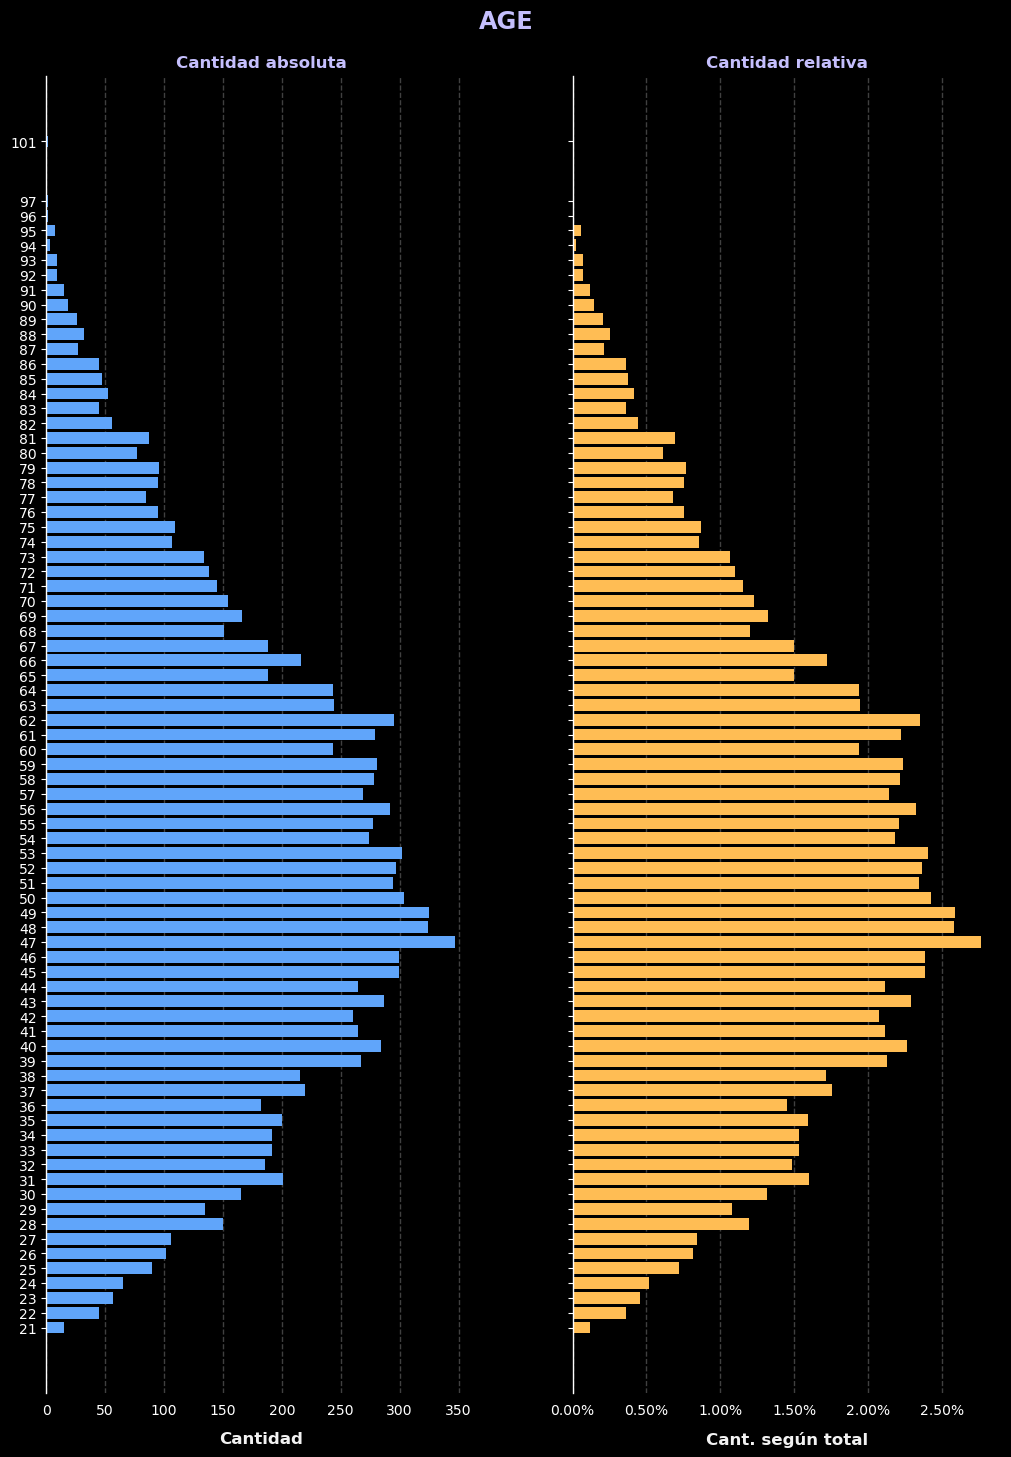

In [11]:
serie = df_credit["age"]

fig, axs = plt.subplots(
	nrows=1,
	ncols=2,
	figsize=(10, 14),
	layout="constrained",
	sharey=True
)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(
	f"{serie.name}".upper(),
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.03
)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(
	y=data.index,
	width=data.values,
	data=data,
	color="#60A5FA",
	zorder=2
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)

axs[0].set_xlabel(
	"Cantidad",
	color="#F2F2F2",
	labelpad=10,
	fontdict=font_config
)
axs[0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(
	y=data.index,
	width=data.values,
	data=data,
	color="#FFBD54",
	zorder=2
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
axs[1].set_xlabel(
	"Cant. según total",
	color="#F2F2F2",
	labelpad=10,
	fontdict=font_config
)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

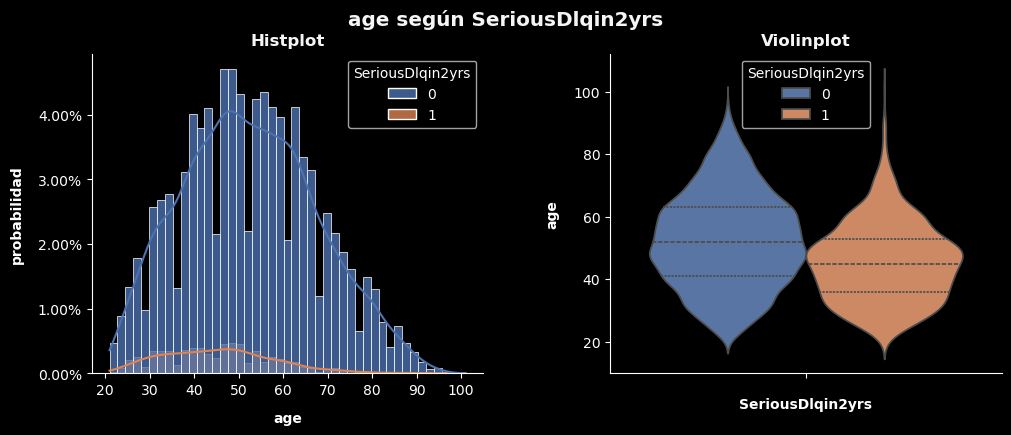

In [12]:
fig, axs = plt.subplots(
	nrows=1,
	ncols=2,
	figsize=(10, 4),
	layout="constrained"
)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(
	"age según SeriousDlqin2yrs",
	color="#F5F5F5",
	fontproperties=font_config,
	y=1.05
)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#F5F5F5", fontdict=font_config)
sns.histplot(
	data=df_credit,
	x="age",
	hue="SeriousDlqin2yrs",
	bins="fd",
	kde=True,
	stat="probability",
	alpha=.8,
	palette="deep",
	ax=axs[0]
)
sns.despine(ax=axs[0])
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("age", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("probabilidad", labelpad=10, fontdict=font_config)
axs[0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Violinplot", color="#F5F5F5", fontdict=font_config)
sns.violinplot(
	data=df_credit,
	y="age",
	inner="quart",
	hue="SeriousDlqin2yrs",
	palette="deep",
	ax=axs[1]
)
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("age", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(wspace=0.125)
plt.show()

#### **`RevolvingUtilizationOfUnsecuredLines`**

In [13]:
def filter_outliers(
	serie: pd.Series,
	whisker: float | None=1.75,
	below_zero=False
) -> pd.Series:
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	return serie[mask]

In [14]:
get_quality(df_credit)

Cardinality  Uniqueness   Null
SeriousDlqin2yrs                              2.0    0.000160    0.0
RevolvingUtilizationOfUnsecuredLines      10764.0    0.858579    0.0
age                                          78.0    0.006222    0.0
NumberOfTime30-59DaysPastDueNotWorse         10.0    0.000798    0.0
DebtRatio                                 11547.0    0.921034    0.0
MonthlyIncome                              4167.0    0.332376  721.0
NumberOfOpenCreditLinesAndLoans              43.0    0.003430    0.0
NumberOfTimes90DaysLate                      13.0    0.001037    0.0
NumberRealEstateLoansOrLines                 16.0    0.001276    0.0
NumberOfTime60-89DaysPastDueNotWorse          8.0    0.000638    0.0
NumberOfDependents                           10.0    0.000798  177.0
age_category                                  4.0    0.000319    0.0

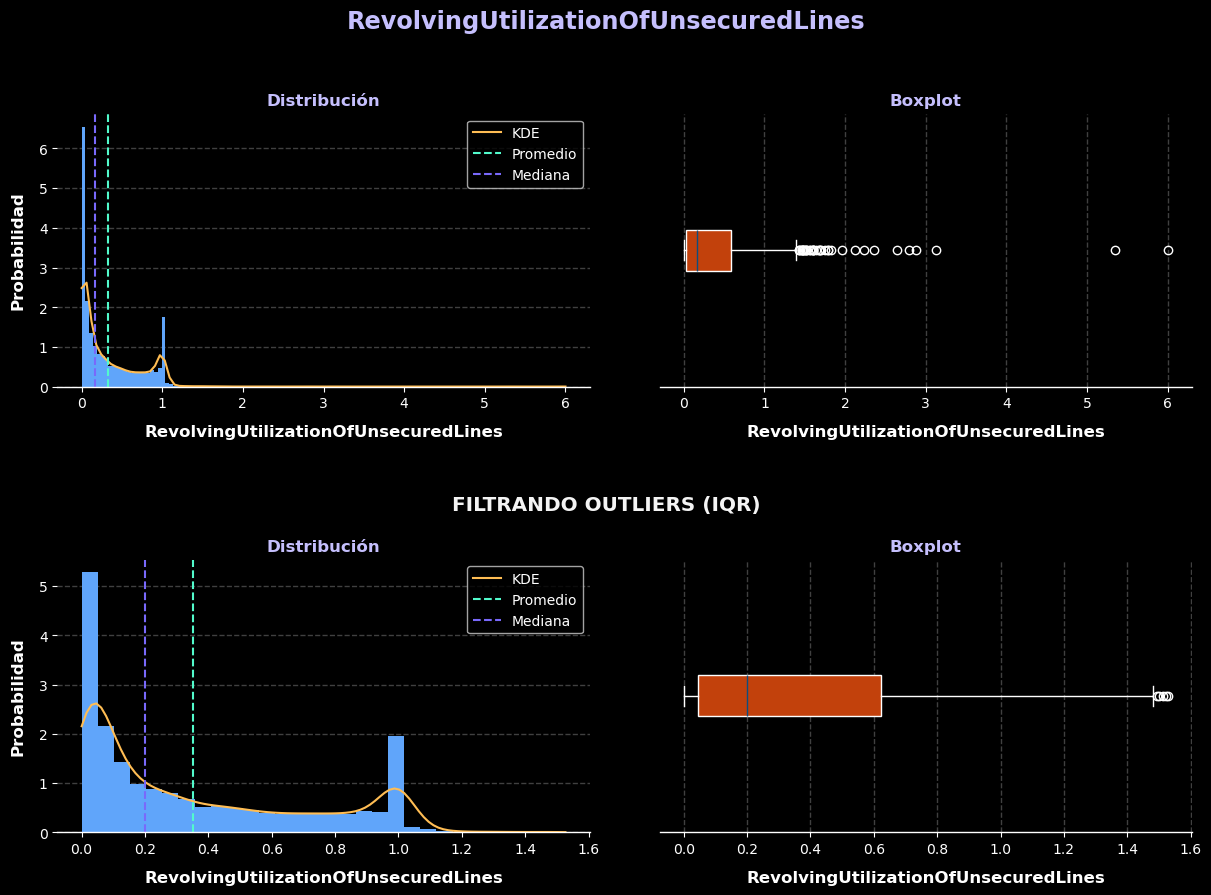

In [15]:
serie = df_credit["RevolvingUtilizationOfUnsecuredLines"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"RevolvingUtilizationOfUnsecuredLines",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0][0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0][0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(
	x=serie,
	boxprops={"facecolor" : "#C2410C"},
	medianprops={"color" : "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(
	0.5, 0.48,
	"FILTRANDO OUTLIERS (IQR)",
	color="#F4F4F4",
	va="center",
	ha="center",
	fontdict=font_config
)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)
x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(
	data.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
axs[1][0].axvline(
	data.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1][1].boxplot(
	x=data,
	boxprops={ "facecolor" : "#C2410C" },
	medianprops={ "color" : "#0F4D7D" },
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

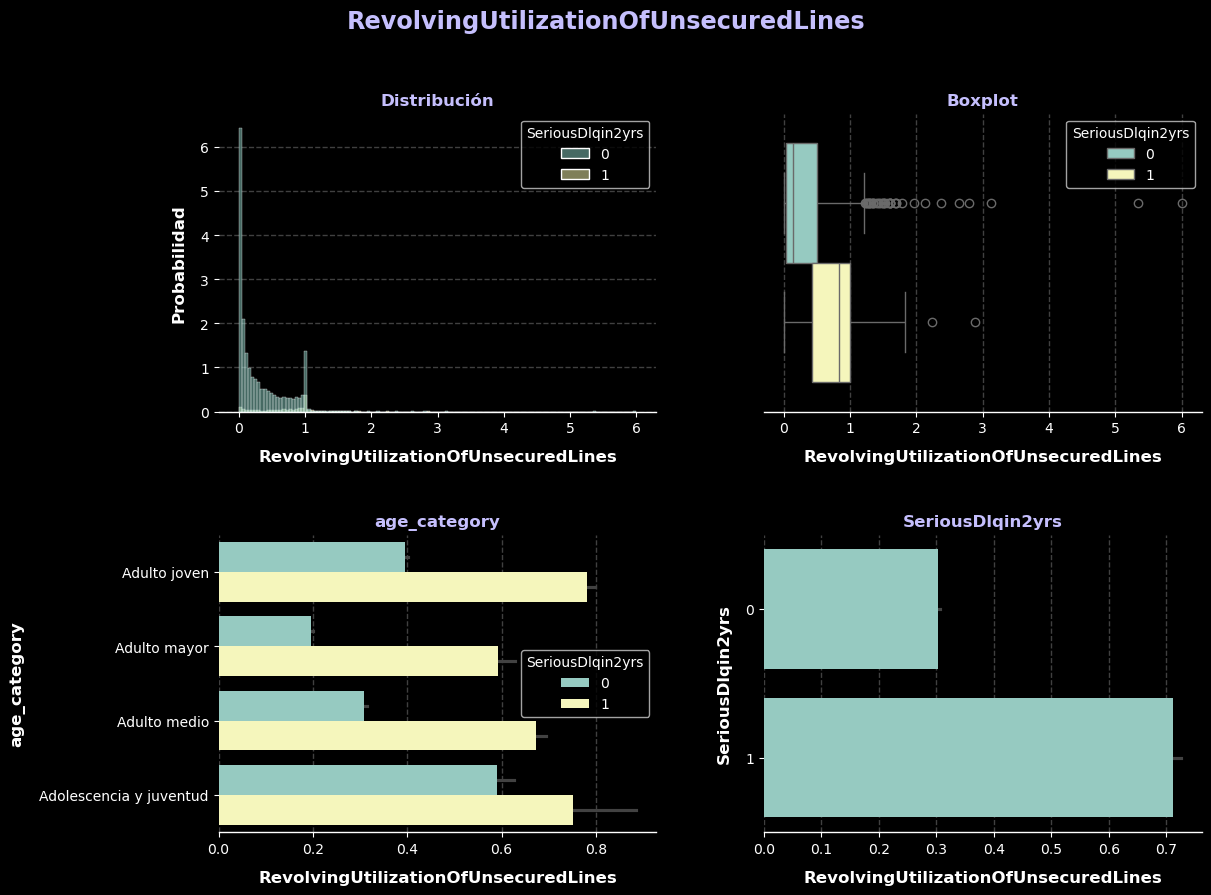

In [16]:
serie = df_credit["RevolvingUtilizationOfUnsecuredLines"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"RevolvingUtilizationOfUnsecuredLines",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)
sns.histplot(
	x="RevolvingUtilizationOfUnsecuredLines",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	bins="fd",
	stat="density",
	palette="Set3",
	zorder=9,
	ax=axs[0][0]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
sns.boxplot(
	x="RevolvingUtilizationOfUnsecuredLines",
	data=df_credit,
	hue="SeriousDlqin2yrs",
	orientation="horizontal",
	zorder=9,
	ax=axs[0][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("age_category", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="RevolvingUtilizationOfUnsecuredLines",
	y="age_category",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	errorbar="se",
	zorder=3,
	ax=axs[1][0]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("age_category", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("SeriousDlqin2yrs", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="RevolvingUtilizationOfUnsecuredLines",
	y="SeriousDlqin2yrs",
	orient="horizontal",
	data=df_credit,
	errorbar="se",
	zorder=9,
	ax=axs[1][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("RevolvingUtilizationOfUnsecuredLines", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.125, wspace=0.10)
plt.show()

#### **`DebtRatio`**

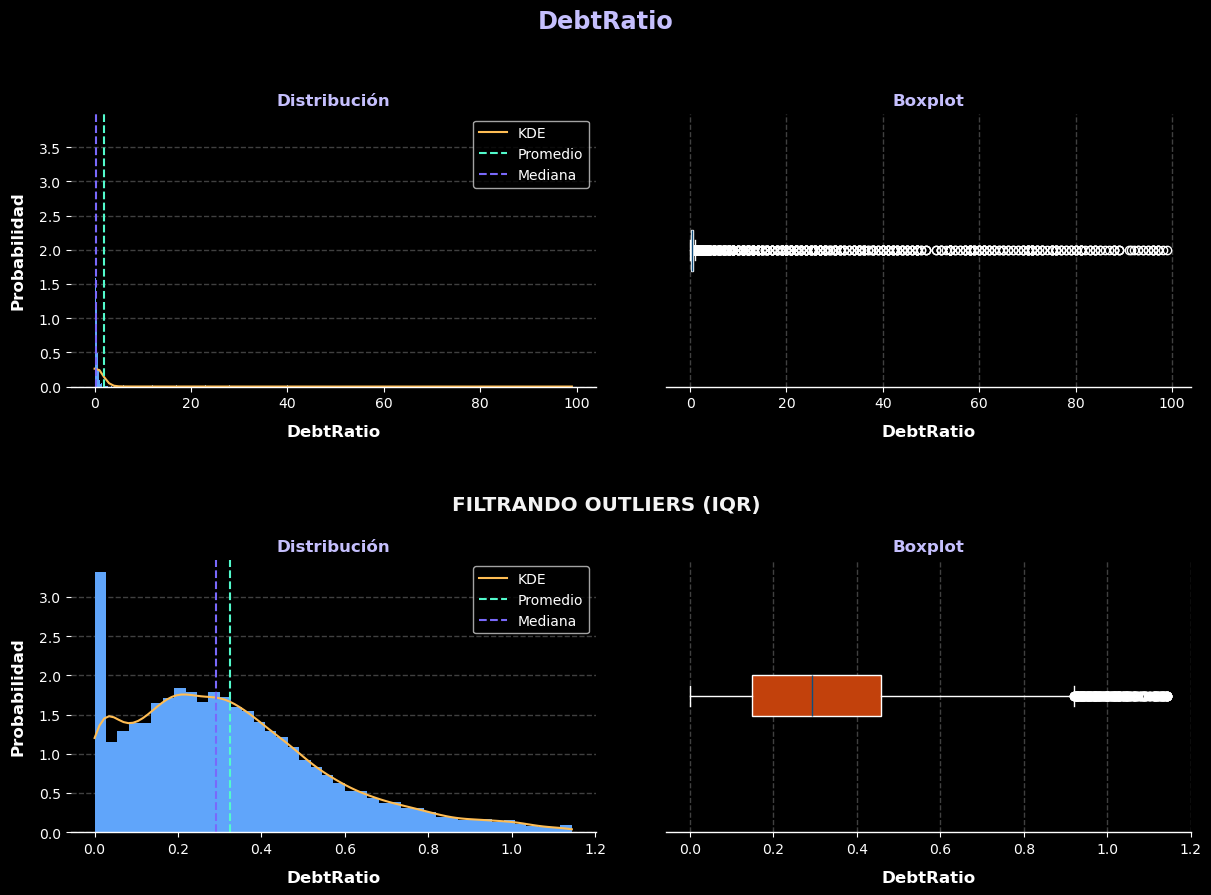

In [17]:
serie = df_credit["DebtRatio"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"DebtRatio",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0][0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0][0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(
	x=serie,
	boxprops={"facecolor" : "#C2410C"},
	medianprops={"color" : "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(
	0.5, 0.48,
	"FILTRANDO OUTLIERS (IQR)",
	color="#F4F4F4",
	va="center",
	ha="center",
	fontdict=font_config
)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)
x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(
	data.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
axs[1][0].axvline(
	data.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1][1].boxplot(
	x=data,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

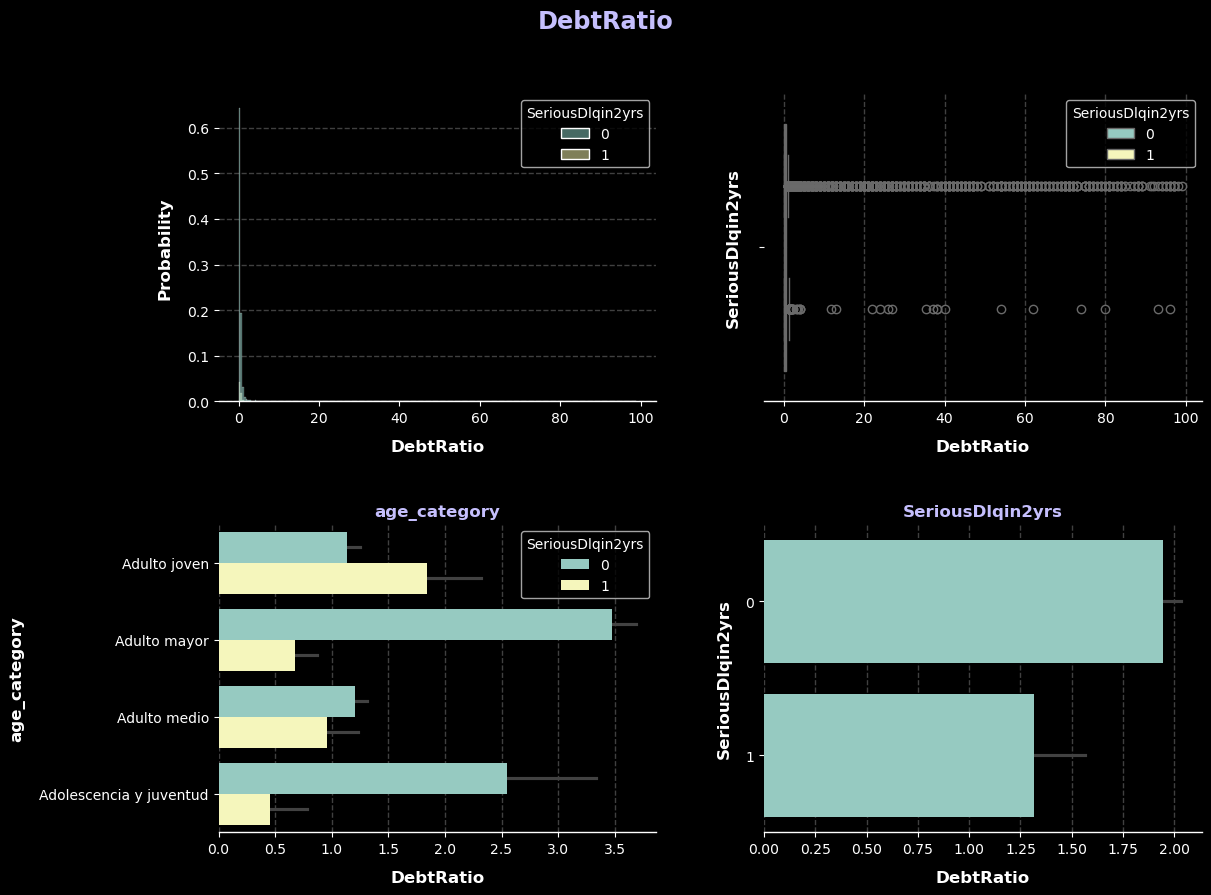

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"DebtRatio",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][0].set_title("Barplot", color="#C5BFFD", fontdict=font_config)
sns.histplot(
	x="DebtRatio",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	bins="auto",
	stat="probability",
	palette="Set3",
	zorder=9,
	ax=axs[0][0]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probability", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
sns.boxplot(
	x="DebtRatio",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	orientation="horizontal",
	zorder=9,
	ax=axs[0][1]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("age_category", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="DebtRatio",
	y="age_category",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	errorbar="se",
	zorder=3,
	ax=axs[1][0]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("age_category", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("SeriousDlqin2yrs", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="DebtRatio",
	y="SeriousDlqin2yrs",
	orient="horizontal",
	data=df_credit,
	errorbar="se",
	zorder=9,
	ax=axs[1][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("DebtRatio", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.125, wspace=0.10)
plt.show()

#### **`MonthlyIncome`**

`MonthlyIncome` posee 721 valores nulos que debemos completar

In [19]:
data = df_credit.groupby(by=["SeriousDlqin2yrs", "age_category"])["MonthlyIncome"].agg(["mean", "median"])
data

mean  median
SeriousDlqin2yrs age_category                                
0                Adolescencia y juventud  1818.014599  1270.0
                 Adulto joven             5856.303222  4899.0
                 Adulto mayor             6966.927484  5303.0
                 Adulto medio             8020.840875  6475.0
1                Adolescencia y juventud  3914.200000  1744.5
                 Adulto joven             5270.549333  4166.0
                 Adulto mayor             5531.577586  4388.5
                 Adulto medio             6826.212766  5556.0

In [20]:
is_na = df_credit["MonthlyIncome"].isna()
df_credit.loc[is_na, :].head()

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
20                 0                                0.0017   91   
25                 0                                0.0000   58   
29                 0                                0.0000   50   
32                 1                                1.0000   43   
66                 0                                1.0000   22   

    NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
20                                     0        1.0            NaN   
25                                     0       71.0            NaN   
29                                     0        0.0            NaN   
32                                    98       96.0            NaN   
66                                     0        0.0            NaN   

    NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
20                                3                        0   
25                                2                        0   
29                               13                        0   
32                                0                       98   
66                                0                        0   

    NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
20                             0                                     0   
25                             0                                     0   
29                             0                                     0   
32                             0                                    98   
66                             0                                     0   

    NumberOfDependents             age_category  
20                 NaN             Adulto mayor  
25                 0.0             Adulto medio  
29                 0.0             Adulto medio  
32                 0.0             Adulto joven  
66                 NaN  Adolescencia y juventud

In [21]:
to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 0 and age_category == 'Adolescencia y juventud'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(0, "Adolescencia y juventud"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 1 and age_category == 'Adolescencia y juventud'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(1, "Adolescencia y juventud"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                     0                              0.081892   37   
1                     0                              0.023413   74   
2                     0                              0.000000   43   
3                     0                              0.492754   44   
4                     0                              1.000000   63   
...                 ...                                   ...  ...   
12532                 0                              0.197116   59   
12533                 0                              0.036726   62   
12534                 0                              0.120313   49   
12535                 0                              0.252566   63   
12536                 0                              0.000000   40   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                         0   0.070709         5656.0   
1                                         0   0.209197         4870.0   
2                                         0   0.080784         5000.0   
3                                         0   0.412735         7333.0   
4                                         0   0.000000         8333.0   
...                                     ...        ...            ...   
12532                                     0   0.290216         5140.0   
12533                                     0   0.884985         5833.0   
12534                                     0   0.577676         6333.0   
12535                                     0   0.037640        14000.0   
12536                                     0   0.455357         3583.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                   12                        1   
1                                    9                        0   
2                                    2                        0   
3                                    4                        0   
4                                    3                        0   
...                                ...                      ...   
12532                                6                        0   
12533                               12                        0   
12534                                7                        0   
12535                                9                        0   
12536                                7                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                 0                                     0   
1                                 1                                     0   
2                                 0                                     0   
3                                 2                                     0   
4                                 0                                     0   
...                             ...                                   ...   
12532                             1                                     0   
12533                             1                                     0   
12534                             2                                     0   
12535                             0                                     0   
12536                             2                                     0   

       NumberOfDependents  age_category  
0                     0.0  Adulto joven  
1                     0.0  Adulto mayor  
2                     2.0  Adulto joven  
3                     3.0  Adulto joven  
4                     1.0  Adulto mayor  
...                   ...           ...  
12532                 0.0  Adulto medio  
12533                 0.0  Adulto mayor  
12534                 2.0  Adulto medio  
12535                 1.0  Adulto mayor  
12536                 1.0  Adulto joven  

[12537 rows x 12 columns]

In [22]:
to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 0 and age_category == 'Adulto joven'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(0, "Adulto joven"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 1 and age_category == 'Adulto joven'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(1, "Adulto joven"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                     0                              0.081892   37   
1                     0                              0.023413   74   
2                     0                              0.000000   43   
3                     0                              0.492754   44   
4                     0                              1.000000   63   
...                 ...                                   ...  ...   
12532                 0                              0.197116   59   
12533                 0                              0.036726   62   
12534                 0                              0.120313   49   
12535                 0                              0.252566   63   
12536                 0                              0.000000   40   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                         0   0.070709         5656.0   
1                                         0   0.209197         4870.0   
2                                         0   0.080784         5000.0   
3                                         0   0.412735         7333.0   
4                                         0   0.000000         8333.0   
...                                     ...        ...            ...   
12532                                     0   0.290216         5140.0   
12533                                     0   0.884985         5833.0   
12534                                     0   0.577676         6333.0   
12535                                     0   0.037640        14000.0   
12536                                     0   0.455357         3583.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                   12                        1   
1                                    9                        0   
2                                    2                        0   
3                                    4                        0   
4                                    3                        0   
...                                ...                      ...   
12532                                6                        0   
12533                               12                        0   
12534                                7                        0   
12535                                9                        0   
12536                                7                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                 0                                     0   
1                                 1                                     0   
2                                 0                                     0   
3                                 2                                     0   
4                                 0                                     0   
...                             ...                                   ...   
12532                             1                                     0   
12533                             1                                     0   
12534                             2                                     0   
12535                             0                                     0   
12536                             2                                     0   

       NumberOfDependents  age_category  
0                     0.0  Adulto joven  
1                     0.0  Adulto mayor  
2                     2.0  Adulto joven  
3                     3.0  Adulto joven  
4                     1.0  Adulto mayor  
...                   ...           ...  
12532                 0.0  Adulto medio  
12533                 0.0  Adulto mayor  
12534                 2.0  Adulto medio  
12535                 1.0  Adulto mayor  
12536                 1.0  Adulto joven  

[12537 rows x 12 columns]

In [23]:
to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 0 and age_category == 'Adulto mayor'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(0, "Adulto mayor"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 1 and age_category == 'Adulto mayor'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(1, "Adulto mayor"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                     0                              0.081892   37   
1                     0                              0.023413   74   
2                     0                              0.000000   43   
3                     0                              0.492754   44   
4                     0                              1.000000   63   
...                 ...                                   ...  ...   
12532                 0                              0.197116   59   
12533                 0                              0.036726   62   
12534                 0                              0.120313   49   
12535                 0                              0.252566   63   
12536                 0                              0.000000   40   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                         0   0.070709         5656.0   
1                                         0   0.209197         4870.0   
2                                         0   0.080784         5000.0   
3                                         0   0.412735         7333.0   
4                                         0   0.000000         8333.0   
...                                     ...        ...            ...   
12532                                     0   0.290216         5140.0   
12533                                     0   0.884985         5833.0   
12534                                     0   0.577676         6333.0   
12535                                     0   0.037640        14000.0   
12536                                     0   0.455357         3583.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                   12                        1   
1                                    9                        0   
2                                    2                        0   
3                                    4                        0   
4                                    3                        0   
...                                ...                      ...   
12532                                6                        0   
12533                               12                        0   
12534                                7                        0   
12535                                9                        0   
12536                                7                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                 0                                     0   
1                                 1                                     0   
2                                 0                                     0   
3                                 2                                     0   
4                                 0                                     0   
...                             ...                                   ...   
12532                             1                                     0   
12533                             1                                     0   
12534                             2                                     0   
12535                             0                                     0   
12536                             2                                     0   

       NumberOfDependents  age_category  
0                     0.0  Adulto joven  
1                     0.0  Adulto mayor  
2                     2.0  Adulto joven  
3                     3.0  Adulto joven  
4                     1.0  Adulto mayor  
...                   ...           ...  
12532                 0.0  Adulto medio  
12533                 0.0  Adulto mayor  
12534                 2.0  Adulto medio  
12535                 1.0  Adulto mayor  
12536                 1.0  Adulto joven  

[12537 rows x 12 columns]

In [24]:
to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 0 and age_category == 'Adulto medio'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(0, "Adulto medio"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

to_impute = df_credit.loc[is_na, :].query("SeriousDlqin2yrs == 1 and age_category == 'Adulto medio'")["MonthlyIncome"]
imputations = to_impute.fillna(data.loc[(1, "Adulto medio"), "median"])
df_credit.fillna(value={"MonthlyIncome": imputations}, inplace=True)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                     0                              0.081892   37   
1                     0                              0.023413   74   
2                     0                              0.000000   43   
3                     0                              0.492754   44   
4                     0                              1.000000   63   
...                 ...                                   ...  ...   
12532                 0                              0.197116   59   
12533                 0                              0.036726   62   
12534                 0                              0.120313   49   
12535                 0                              0.252566   63   
12536                 0                              0.000000   40   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                         0   0.070709         5656.0   
1                                         0   0.209197         4870.0   
2                                         0   0.080784         5000.0   
3                                         0   0.412735         7333.0   
4                                         0   0.000000         8333.0   
...                                     ...        ...            ...   
12532                                     0   0.290216         5140.0   
12533                                     0   0.884985         5833.0   
12534                                     0   0.577676         6333.0   
12535                                     0   0.037640        14000.0   
12536                                     0   0.455357         3583.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                                   12                        1   
1                                    9                        0   
2                                    2                        0   
3                                    4                        0   
4                                    3                        0   
...                                ...                      ...   
12532                                6                        0   
12533                               12                        0   
12534                                7                        0   
12535                                9                        0   
12536                                7                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                                 0                                     0   
1                                 1                                     0   
2                                 0                                     0   
3                                 2                                     0   
4                                 0                                     0   
...                             ...                                   ...   
12532                             1                                     0   
12533                             1                                     0   
12534                             2                                     0   
12535                             0                                     0   
12536                             2                                     0   

       NumberOfDependents  age_category  
0                     0.0  Adulto joven  
1                     0.0  Adulto mayor  
2                     2.0  Adulto joven  
3                     3.0  Adulto joven  
4                     1.0  Adulto mayor  
...                   ...           ...  
12532                 0.0  Adulto medio  
12533                 0.0  Adulto mayor  
12534                 2.0  Adulto medio  
12535                 1.0  Adulto mayor  
12536                 1.0  Adulto joven  

[12537 rows x 12 columns]

In [25]:
is_na = df_credit["MonthlyIncome"].isna()
df_credit.loc[is_na, :]

Empty DataFrame
Columns: [SeriousDlqin2yrs, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, age_category]
Index: []

Realizada la imputación de los valores nulos, analizamos la variable

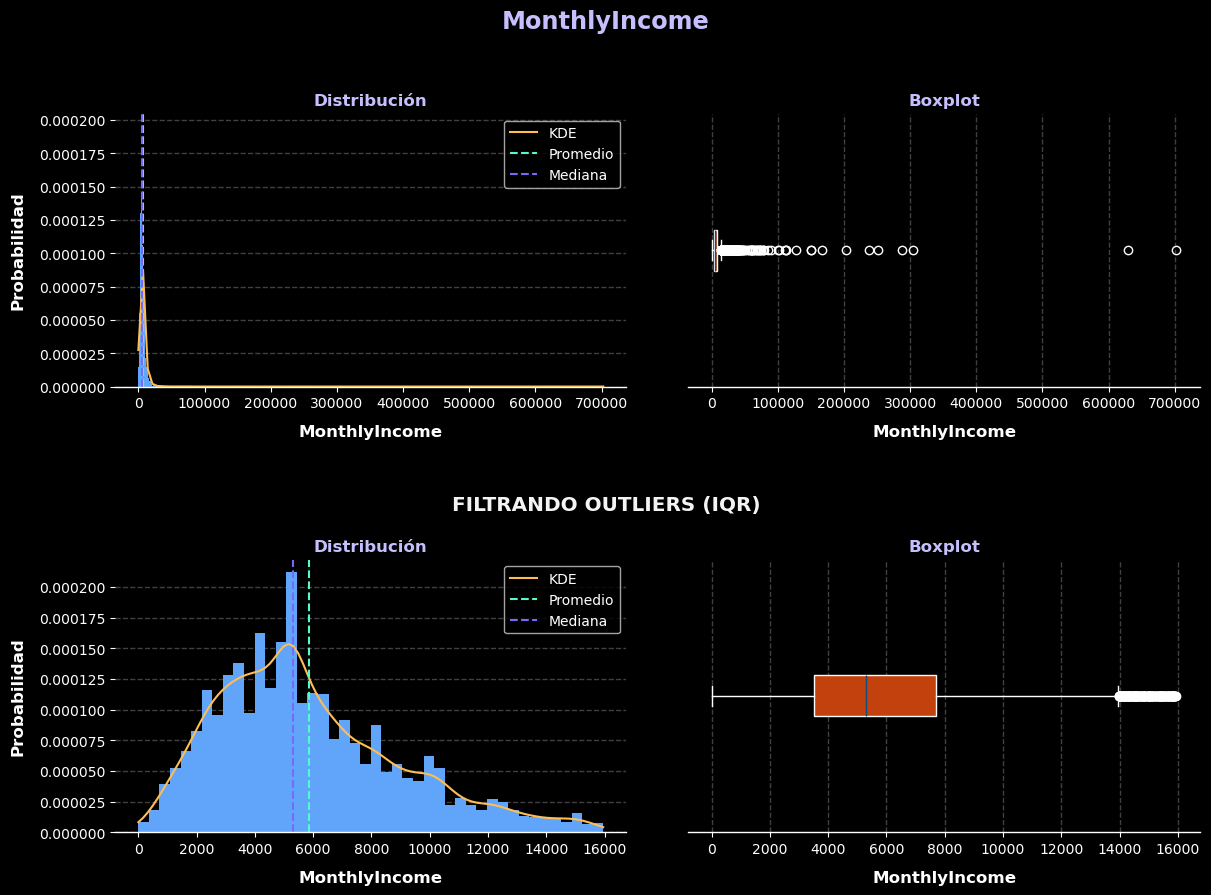

In [26]:
serie = df_credit["MonthlyIncome"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"MonthlyIncome",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0][0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0][0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(
	x=serie,
	boxprops={"facecolor" : "#C2410C"},
	medianprops={"color" : "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(
	0.5, 0.48,
	"FILTRANDO OUTLIERS (IQR)",
	color="#F4F4F4",
	va="center",
	ha="center",
	fontdict=font_config
)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)
x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(
	data.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
axs[1][0].axvline(
	data.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1][1].boxplot(
	x=data,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

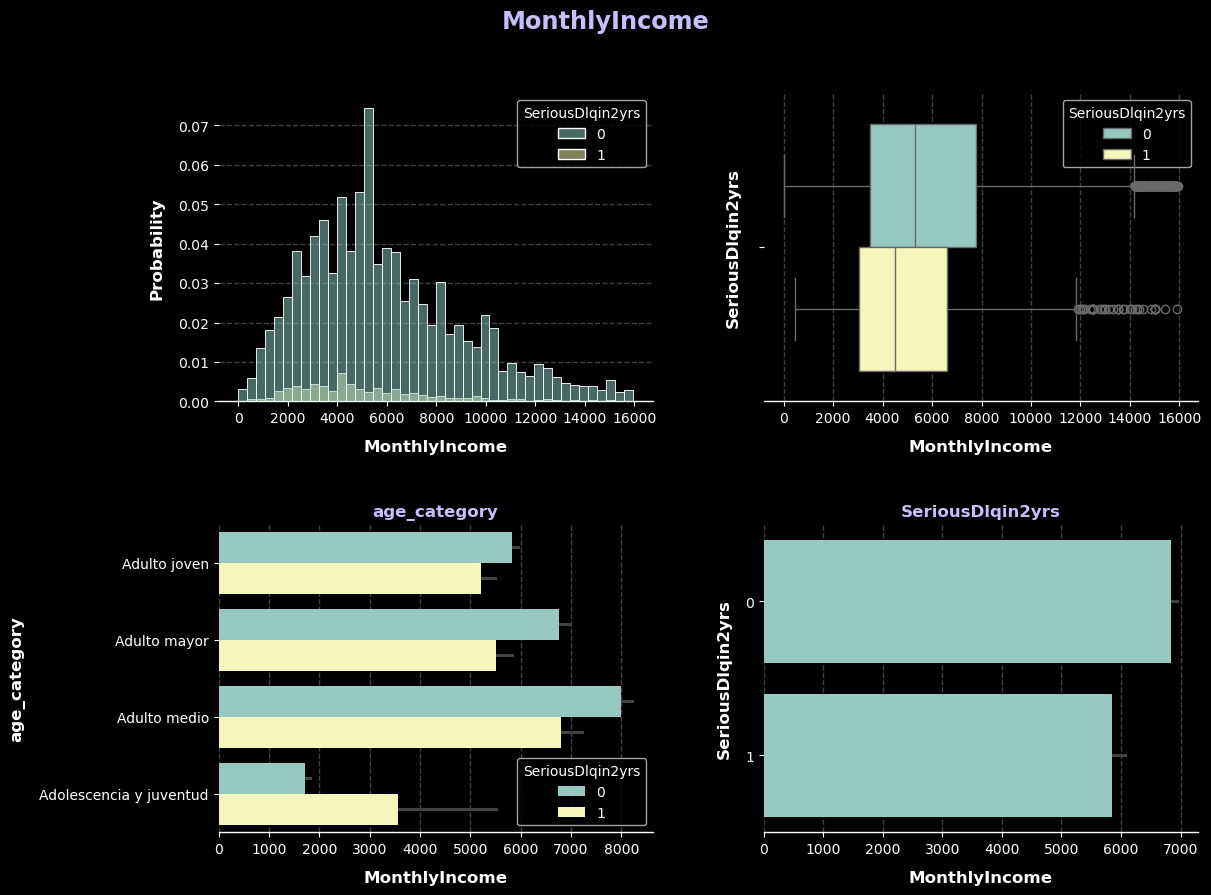

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"MonthlyIncome",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][0].set_title("Barplot", color="#C5BFFD", fontdict=font_config)
data = df_credit[["MonthlyIncome", "SeriousDlqin2yrs"]]
sns.histplot(
	x=filter_outliers(data["MonthlyIncome"]),
	hue="SeriousDlqin2yrs",
	data=data,
	bins="auto",
	stat="probability",
	palette="Set3",
	zorder=9,
	ax=axs[0][0]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probability", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
data = df_credit[["MonthlyIncome", "SeriousDlqin2yrs"]]
sns.boxplot(
	x=filter_outliers(data["MonthlyIncome"]),
	hue="SeriousDlqin2yrs",
	data=data,
	orientation="horizontal",
	zorder=9,
	ax=axs[0][1]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("age_category", color="#C5BFFD", fontdict=font_config)
data = df_credit[["MonthlyIncome", "SeriousDlqin2yrs"]]
sns.barplot(
	x="MonthlyIncome",
	y="age_category",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	errorbar="se",
	zorder=3,
	ax=axs[1][0]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("age_category", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("SeriousDlqin2yrs", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="MonthlyIncome",
	y="SeriousDlqin2yrs",
	orient="horizontal",
	data=df_credit,
	errorbar="se",
	zorder=9,
	ax=axs[1][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("MonthlyIncome", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.125, wspace=0.10)
plt.show()

#### **`NumberOfOpenCreditLinesAndLoans`**

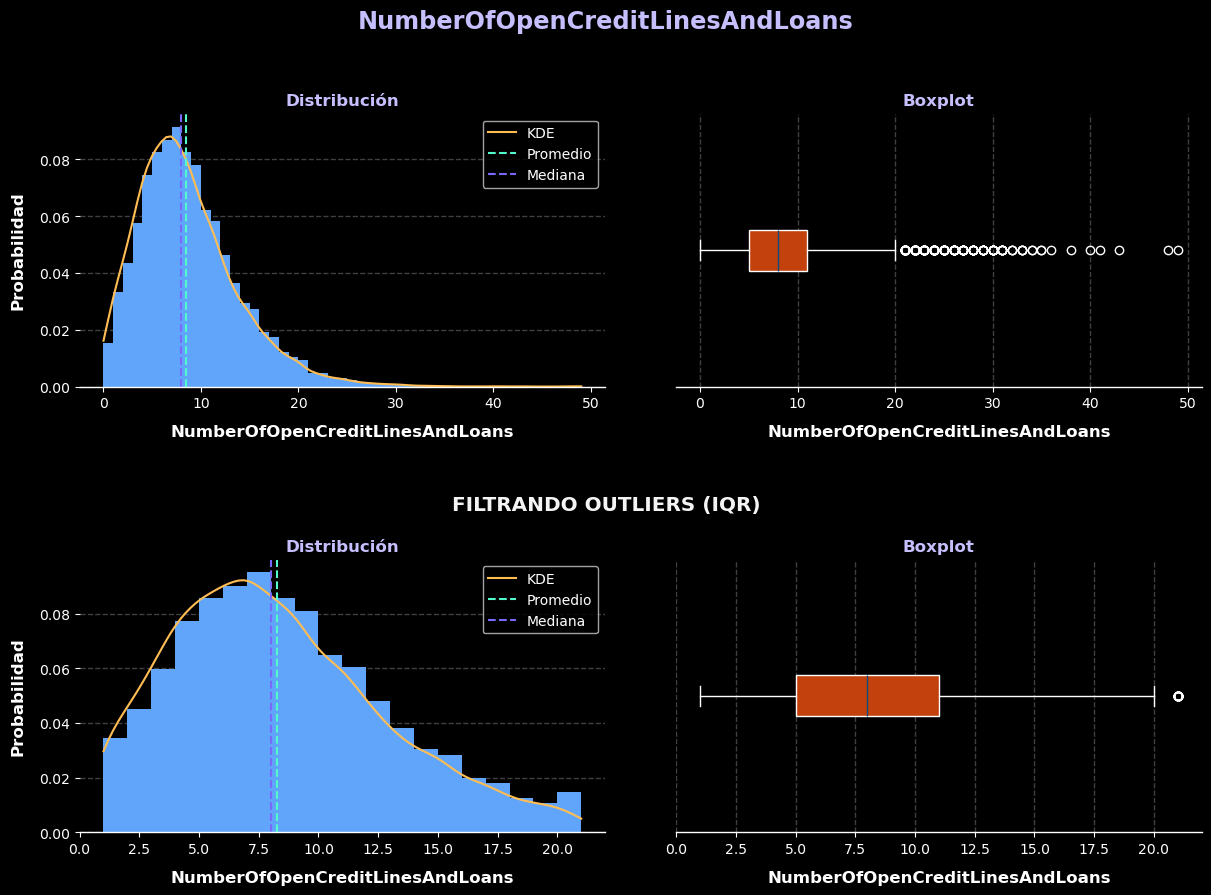

In [28]:
serie = df_credit["NumberOfOpenCreditLinesAndLoans"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfOpenCreditLinesAndLoans",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0][0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0][0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(
	x=serie,
	boxprops={"facecolor" : "#C2410C"},
	medianprops={"color" : "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(
	0.5, 0.48,
	"FILTRANDO OUTLIERS (IQR)",
	color="#F4F4F4",
	va="center",
	ha="center",
	fontdict=font_config
)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)
x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(
	data.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
axs[1][0].axvline(
	data.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1][1].boxplot(
	x=data,
	boxprops={ "facecolor" : "#C2410C" },
	medianprops={ "color" : "#0F4D7D" },
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

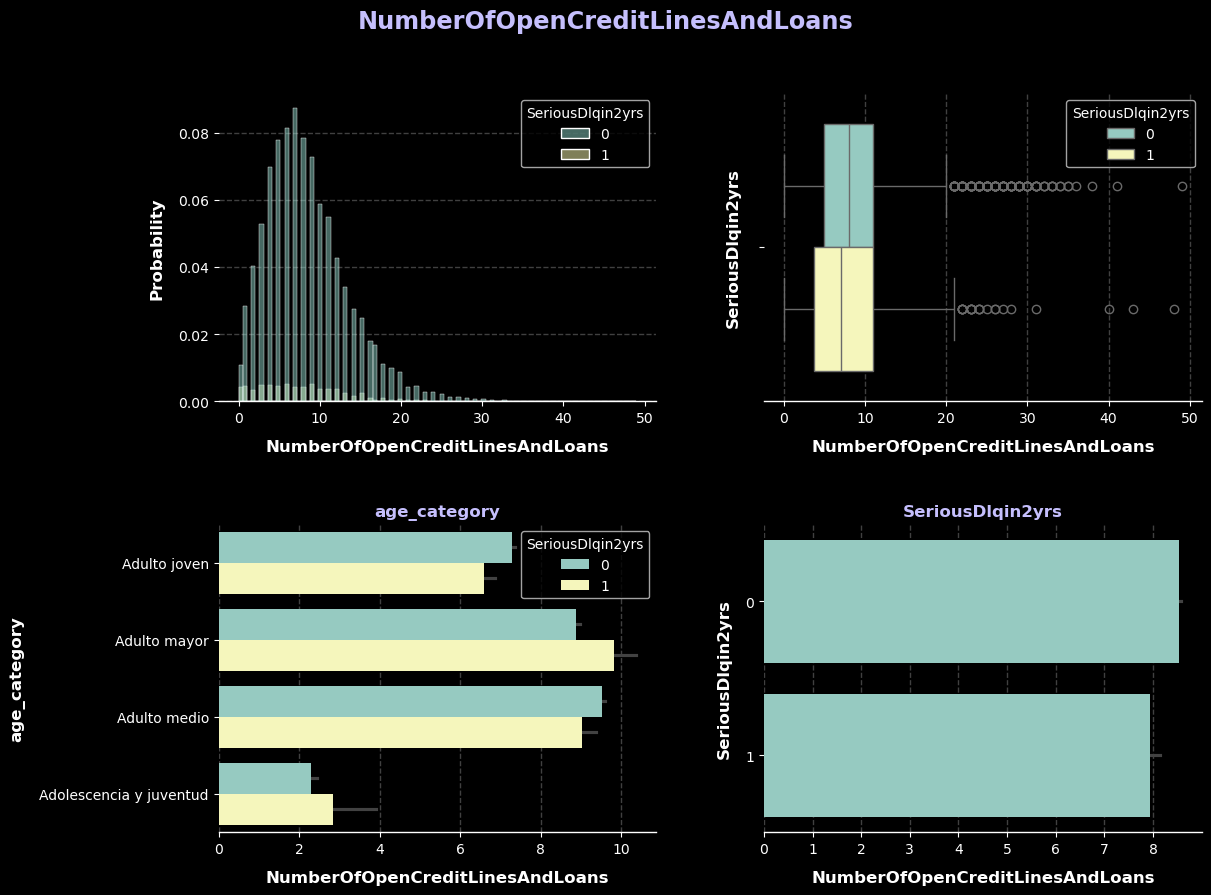

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfOpenCreditLinesAndLoans",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][0].set_title("Barplot", color="#C5BFFD", fontdict=font_config)
sns.histplot(
	x="NumberOfOpenCreditLinesAndLoans",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	bins="fd",
	stat="probability",
	palette="Set3",
	zorder=9,
	ax=axs[0][0]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probability", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
sns.boxplot(
	x="NumberOfOpenCreditLinesAndLoans",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	orientation="horizontal",
	zorder=9,
	ax=axs[0][1]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("age_category", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="NumberOfOpenCreditLinesAndLoans",
	y="age_category",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	errorbar="se",
	zorder=3,
	ax=axs[1][0]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("age_category", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("SeriousDlqin2yrs", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="NumberOfOpenCreditLinesAndLoans",
	y="SeriousDlqin2yrs",
	orient="horizontal",
	data=df_credit,
	errorbar="se",
	zorder=9,
	ax=axs[1][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("NumberOfOpenCreditLinesAndLoans", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.125, wspace=0.10)
plt.show()

#### **`NumberRealEstateLoansOrLines`**

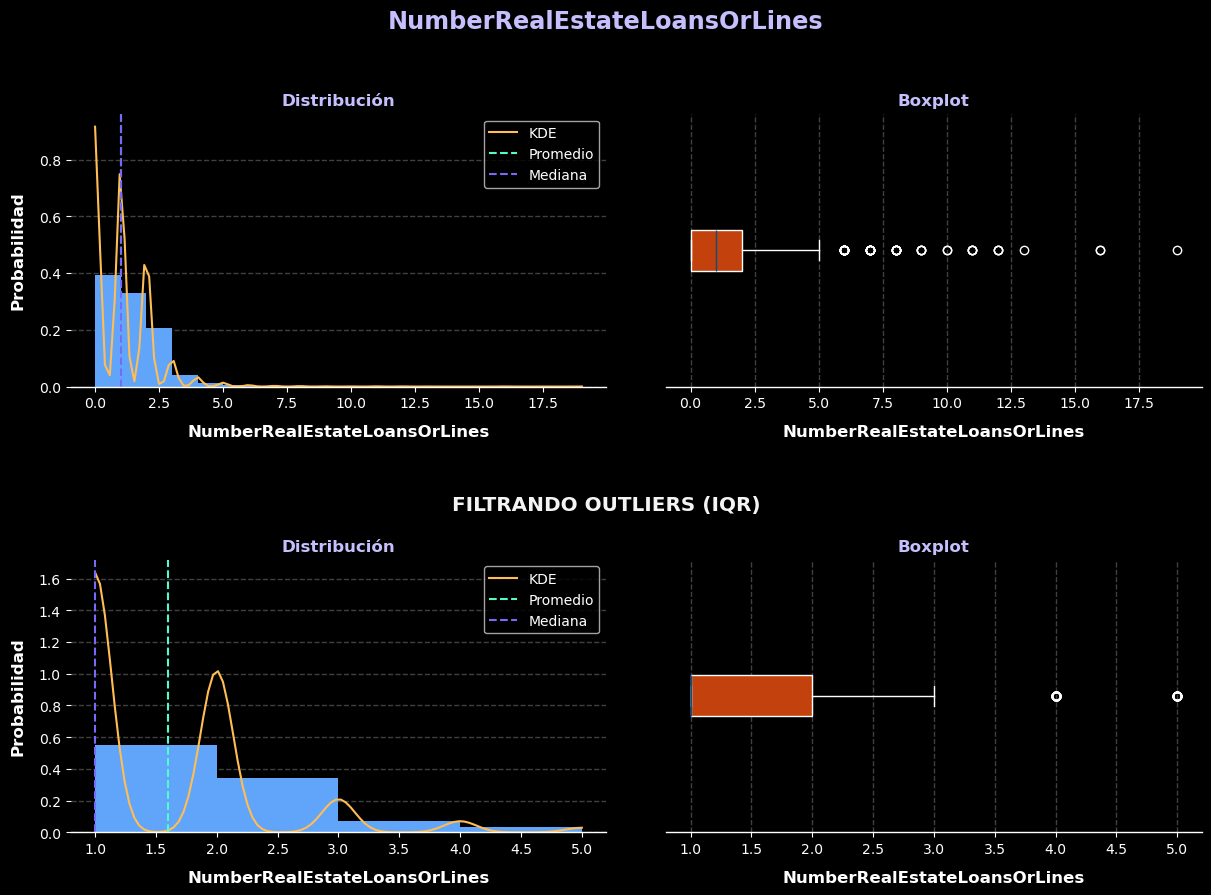

In [30]:
serie = df_credit["NumberRealEstateLoansOrLines"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberRealEstateLoansOrLines",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0][0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0][0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("NumberRealEstateLoansOrLines", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(
	x=serie,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("NumberRealEstateLoansOrLines", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(
	0.5, 0.48,
	"FILTRANDO OUTLIERS (IQR)",
	color="#F4F4F4",
	va="center",
	ha="center",
	fontdict=font_config
)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)
x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(
	data.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
axs[1][0].axvline(
	data.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("NumberRealEstateLoansOrLines", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1][1].boxplot(
	x=data,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("NumberRealEstateLoansOrLines", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

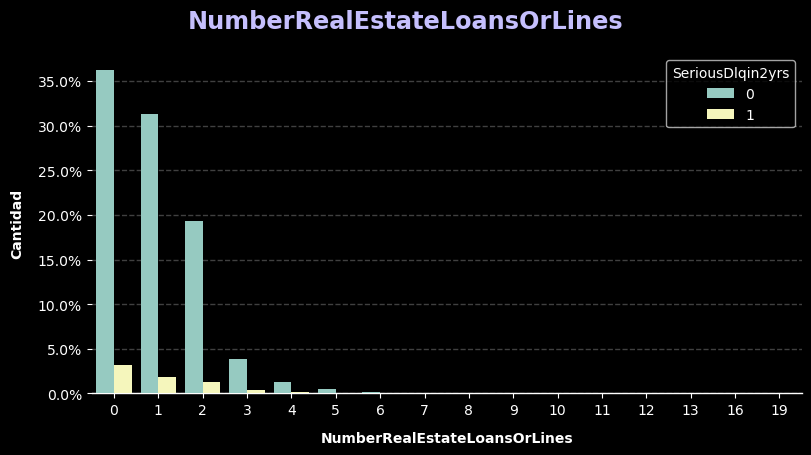

In [31]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberRealEstateLoansOrLines",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.countplot(
	x="NumberRealEstateLoansOrLines",
	data=df_credit,
	hue="SeriousDlqin2yrs",
	stat="percent",
	zorder=9,
	ax=ax
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("NumberRealEstateLoansOrLines", labelpad=10, fontdict=font_config)
ax.set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
ax.grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)

#### **`NumberOfTime30-59DaysPastDueNotWorse`**

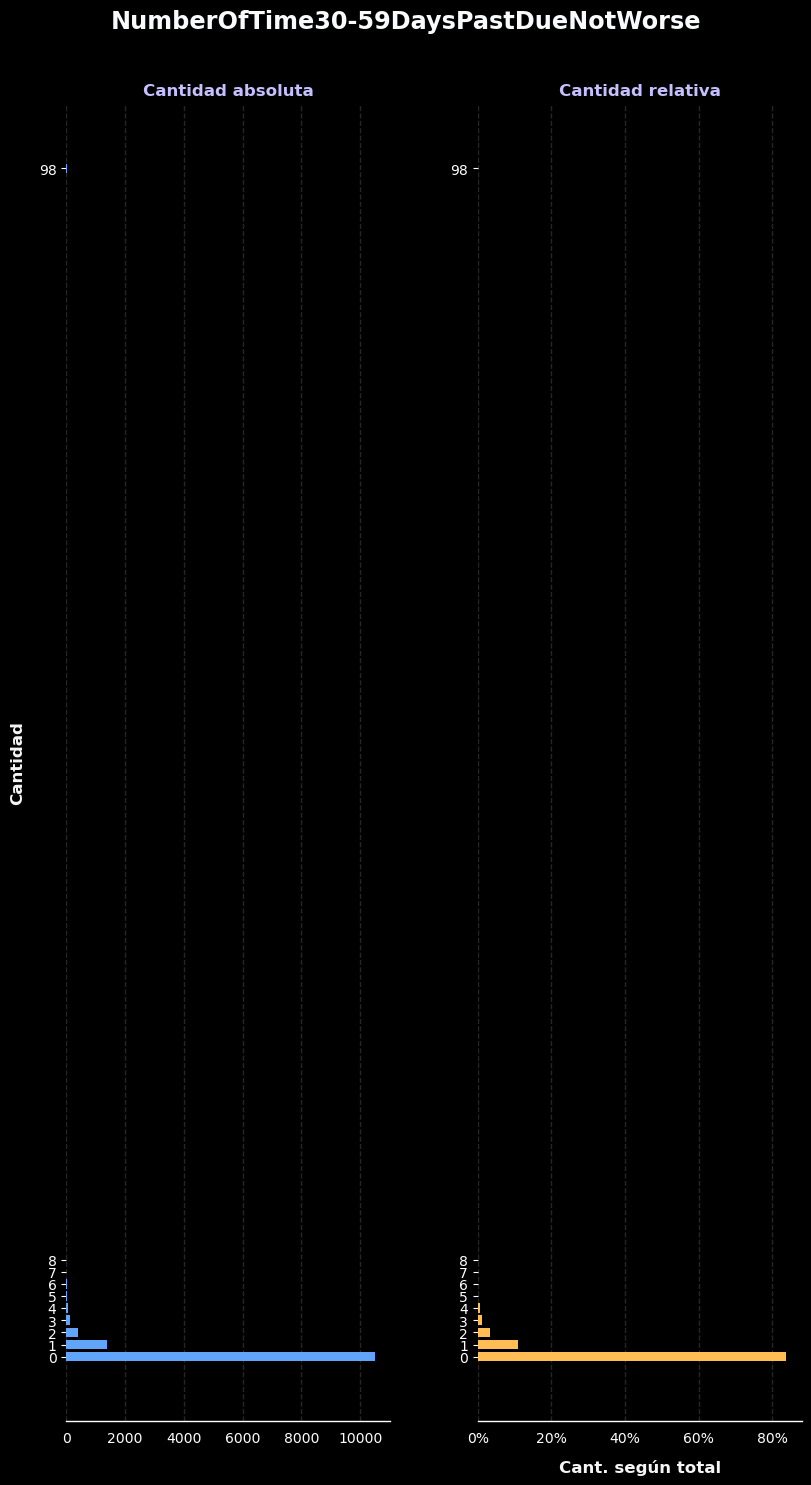

In [32]:
serie = df_credit["NumberOfTime30-59DaysPastDueNotWorse"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 14), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTime30-59DaysPastDueNotWorse",
	color="#F8FAFC",
	fontproperties=font_config,
	y=1.05
)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(
	y=data.index,
	width=data.values,
	data=data,
	color="#60A5FA",
	zorder=2
)

font_config = {
	"color": "#F5F5F5",
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)

axs[0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0].grid(
	axis="x",
	alpha=1,
	color="#262626",
	linestyle="dashed",
	linewidth=1
)
axs[0].spines[["left", "top", "right"]].set_visible(False)
axs[0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
rect = axs[1].barh(
	y=data.index,
	width=data.values,
	data=data,
	color="#FFBD54",
	zorder=2
)
#axs[1].bar_label(rect, fmt=lambda x: f"{x * 100:.2f}")

font_config = {
	"color": "#F5F5F5",
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(
	axis="x",
	alpha=1,
	color="#262626",
	linestyle="dashed",
	linewidth=1
)

axs[1].spines[["left", "top", "right"]].set_visible(False)
axs[1].spines["bottom"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

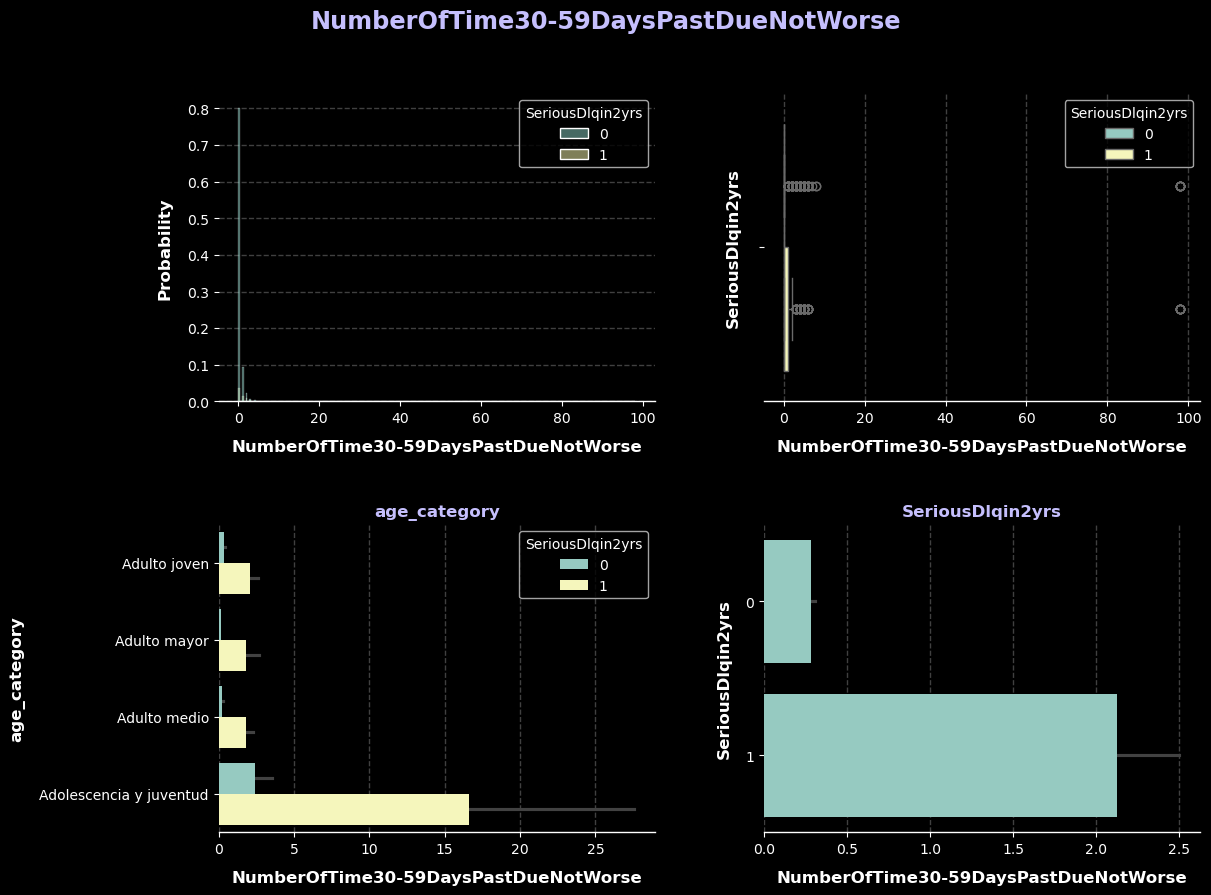

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTime30-59DaysPastDueNotWorse",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][0].set_title("Barplot", color="#C5BFFD", fontdict=font_config)
sns.histplot(
	x="NumberOfTime30-59DaysPastDueNotWorse",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	bins="auto",
	stat="probability",
	palette="Set3",
	zorder=9,
	ax=axs[0][0]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("NumberOfTime30-59DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probability", labelpad=10, fontdict=font_config)
axs[0][0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)




# font_config = {
# 	"family": "sans-serif",
# 	"size": "large",
# 	"weight": "heavy"
# }
# axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
sns.boxplot(
	x="NumberOfTime30-59DaysPastDueNotWorse",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	orientation="horizontal",
	zorder=9,
	ax=axs[0][1]
)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_xlabel("NumberOfTime30-59DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[0][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("age_category", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="NumberOfTime30-59DaysPastDueNotWorse",
	y="age_category",
	hue="SeriousDlqin2yrs",
	data=df_credit,
	errorbar="se",
	zorder=3,
	ax=axs[1][0]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("NumberOfTime30-59DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("age_category", labelpad=10, fontdict=font_config)
axs[1][0].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("SeriousDlqin2yrs", color="#C5BFFD", fontdict=font_config)
sns.barplot(
	x="NumberOfTime30-59DaysPastDueNotWorse",
	y="SeriousDlqin2yrs",
	orient="horizontal",
	data=df_credit,
	errorbar="se",
	zorder=9,
	ax=axs[1][1]
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("NumberOfTime30-59DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("SeriousDlqin2yrs", labelpad=10, fontdict=font_config)
axs[1][1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.125, wspace=0.10)
plt.show()

#### **`NumberOfTime60-89DaysPastDueNotWorse`**

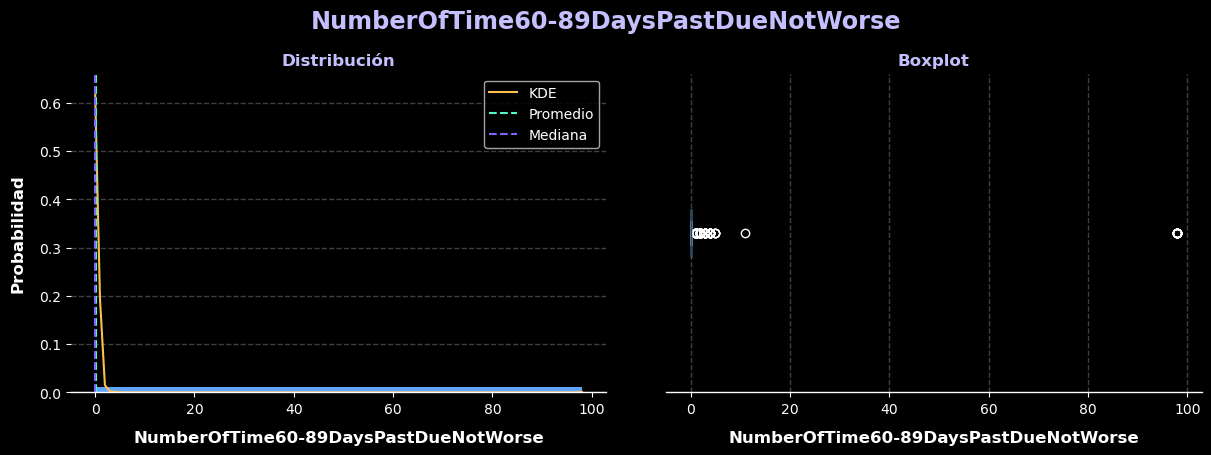

In [34]:
serie = df_credit["NumberOfTime60-89DaysPastDueNotWorse"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTime60-89DaysPastDueNotWorse",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
ax[0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
ax[0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
ax[0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
ax[0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
ax[0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
ax[0].set_xlabel("NumberOfTime60-89DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
ax[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
ax[0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
ax[0].spines[["left", "top", "right"]].set_visible(False)
ax[0].spines["bottom"].set_linewidth(1)
ax[0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
ax[1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
ax[1].boxplot(
	x=serie,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
ax[1].set_yticks([])
ax[1].set_xlabel("NumberOfTime60-89DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
ax[1].set_ylabel("")
ax[1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax[1].spines[["left", "top", "right"]].set_visible(False)
ax[1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(wspace=.1)
plt.show()

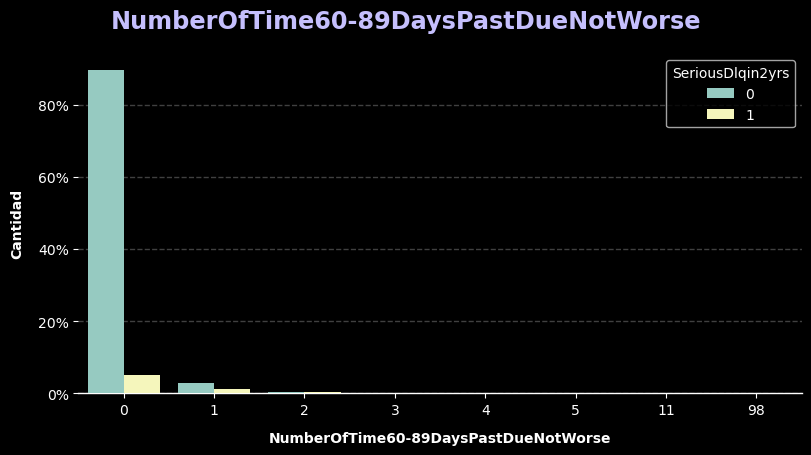

In [35]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTime60-89DaysPastDueNotWorse",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.countplot(
	x="NumberOfTime60-89DaysPastDueNotWorse",
	data=df_credit,
	hue="SeriousDlqin2yrs",
	stat="percent",
	zorder=9,
	ax=ax
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("NumberOfTime60-89DaysPastDueNotWorse", labelpad=10, fontdict=font_config)
ax.set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
ax.grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)

#### **`NumberOfTimes90DaysLate`**

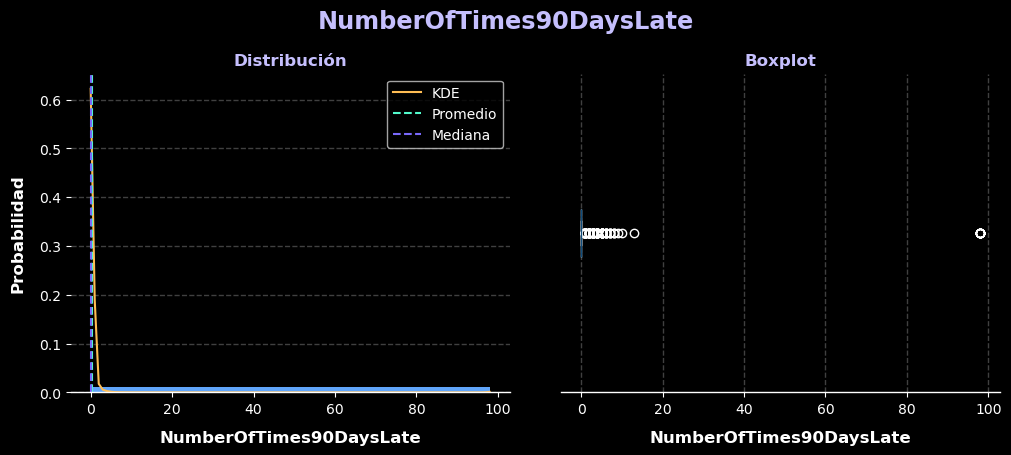

In [36]:
serie = df_credit["NumberOfTimes90DaysLate"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTimes90DaysLate",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
axs[0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
axs[0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].set_xlabel("NumberOfTimes90DaysLate", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
axs[0].spines[["left", "top", "right"]].set_visible(False)
axs[0].spines["bottom"].set_linewidth(1)
axs[0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[1].boxplot(
	x=serie,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks([])
axs[1].set_xlabel("NumberOfTimes90DaysLate", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("")
axs[1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

axs[1].spines[["left", "top", "right"]].set_visible(False)
axs[1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

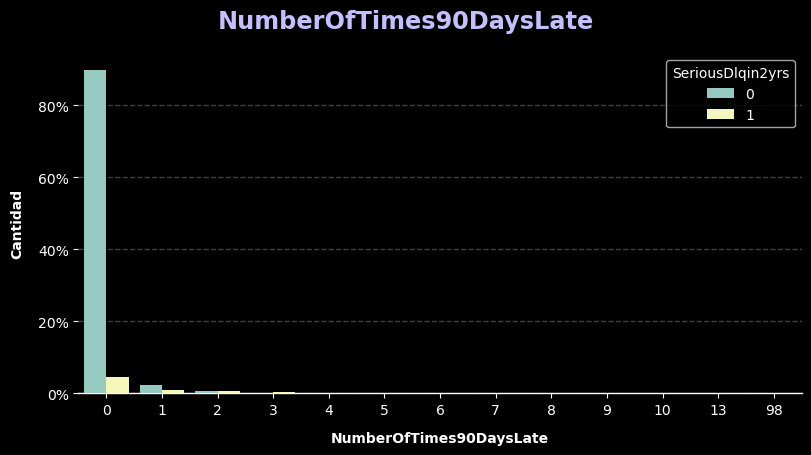

In [37]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfTimes90DaysLate",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.countplot(
	x="NumberOfTimes90DaysLate",
	data=df_credit,
	hue="SeriousDlqin2yrs",
	stat="percent",
	zorder=9,
	ax=ax
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("NumberOfTimes90DaysLate", labelpad=10, fontdict=font_config)
ax.set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
ax.grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)

#### **`NumberOfDependents`**

In [38]:
mode = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adolescencia y juventud'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adolescencia y juventud'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
11725                 0                              0.009050   31   
9248                  0                              0.044112   46   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
11725                                     0   0.001999         2500.0   
9248                                      0  35.000000         6475.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
11725                                2                        0   
9248                                 4                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
11725                             0                                     0   
9248                              0                                     0   

       NumberOfDependents  age_category  
11725                 0.0  Adulto joven  
9248                  NaN  Adulto medio

In [39]:
mode = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adolescencia y juventud'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adolescencia y juventud'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
5848                 0                              0.074576   56   
6427                 0                              0.091432   63   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
5848                                     0   0.473390         3400.0   
6427                                     0   0.308829        14350.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
5848                               30                        0   
6427                               11                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
5848                             1                                     0   
6427                             3                                     0   

      NumberOfDependents  age_category  
5848                 1.0  Adulto medio  
6427                 0.0  Adulto mayor

In [40]:
mode = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto joven'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto joven'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
3399                 0                              0.560604   29   
4137                 0                              0.017446   49   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
3399                                     0   0.174984         4788.0   
4137                                     0   0.163202         7070.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
3399                                6                        0   
4137                               10                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
3399                             0                                     0   
4137                             1                                     0   

      NumberOfDependents  age_category  
3399                 1.0  Adulto joven  
4137                 1.0  Adulto medio

In [41]:
mode = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto joven'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto joven'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
5170                 0                              0.936214   42   
6237                 0                              0.013466   32   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
5170                                     2   0.564631         8300.0   
6237                                     0   0.134173         5000.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
5170                               11                        0   
6237                                5                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
5170                             3                                     0   
6237                             0                                     0   

      NumberOfDependents  age_category  
5170                 4.0  Adulto joven  
6237                 0.0  Adulto joven

In [42]:
mode = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto mayor'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto mayor'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
5530                 0                              0.604743   31   
500                  0                              0.002342   45   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
5530                                     1   0.159280         3000.0   
500                                      0   1.027993         3750.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
5530                                5                        0   
500                                 6                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
5530                             0                                     0   
500                              1                                     0   

      NumberOfDependents  age_category  
5530                 0.0  Adulto joven  
500                  2.0  Adulto medio

In [43]:
mode = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto mayor'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto mayor'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
9065                 0                              0.000000   65   
8074                 0                              0.090557   39   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
9065                                     0   0.000000         2166.0   
8074                                     0   0.407236        11000.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
9065                                2                        0   
8074                                7                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
9065                             0                                     0   
8074                             2                                     0   

      NumberOfDependents  age_category  
9065                 0.0  Adulto mayor  
8074                 3.0  Adulto joven

In [44]:
mode = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto medio'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 1 and age_category == 'Adulto medio'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
3356                 0                              0.113429   71   
6369                 0                              0.061747   85   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
3356                                     0   0.352059         7600.0   
6369                                     0  41.000000         5303.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
3356                               13                        0   
6369                                7                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
3356                             2                                     0   
6369                             0                                     0   

      NumberOfDependents  age_category  
3356                 0.0  Adulto mayor  
6369                 0.0  Adulto mayor

In [45]:
mode = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto medio'")["NumberOfDependents"].mode()[0]
imputations = df_credit.query("SeriousDlqin2yrs == 0 and age_category == 'Adulto medio'")["NumberOfDependents"].fillna(mode)
df_credit.fillna(value={"NumberOfDependents": imputations}, inplace=True).sample(2)

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
4983                 0                              0.031933   70   
2056                 0                              0.001231   70   

      NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
4983                                     0   0.053541         5957.0   
2056                                     0   0.003199         2500.0   

      NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
4983                                9                        0   
2056                               10                        0   

      NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
4983                             1                                     0   
2056                             0                                     0   

      NumberOfDependents  age_category  
4983                 0.0  Adulto mayor  
2056                 0.0  Adulto mayor

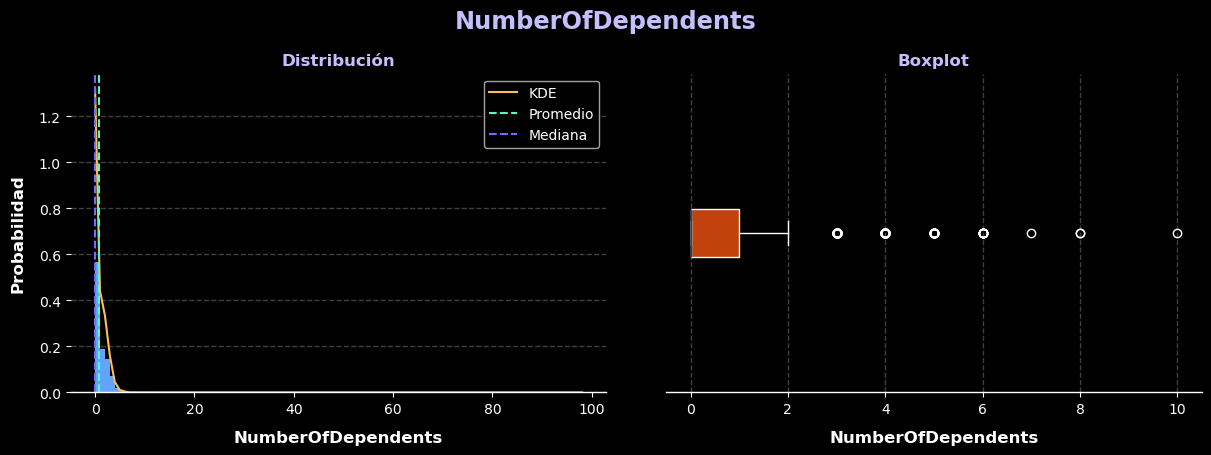

In [46]:
serie = df_credit["NumberOfDependents"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfDependents",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
ax[0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

#bins = np.histogram_bin_edges(serie, bins="fd")
ax[0].hist(x=serie, density=True, color="#60A5FA", zorder=2)

#x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
ax[0].plot(x, kde(x), color="#FFBD54", label="KDE")

# PROMEDIO
ax[0].axvline(
	serie.mean(),
	linestyle="dashed",
	color="#52FACC",
	label="Promedio"
)
# MEDIANA
ax[0].axvline(
	serie.median(),
	linestyle="dashed",
	color="#7969FB",
	label="Mediana"
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
ax[0].set_xlabel("NumberOfDependents", labelpad=10, fontdict=font_config)
ax[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
ax[0].grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)
ax[0].spines[["left", "top", "right"]].set_visible(False)
ax[0].spines["bottom"].set_linewidth(1)
ax[0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
ax[1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
ax[1].boxplot(
	x=serie,
	boxprops={"facecolor": "#C2410C"},
	medianprops={"color": "#0F4D7D"},
	orientation="horizontal",
	patch_artist=True
)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
ax[1].set_yticks([])
ax[1].set_xlabel("NumberOfDependents", labelpad=10, fontdict=font_config)
ax[1].set_ylabel("")
ax[1].grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax[1].spines[["left", "top", "right"]].set_visible(False)
ax[1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(wspace=.1)
plt.show()

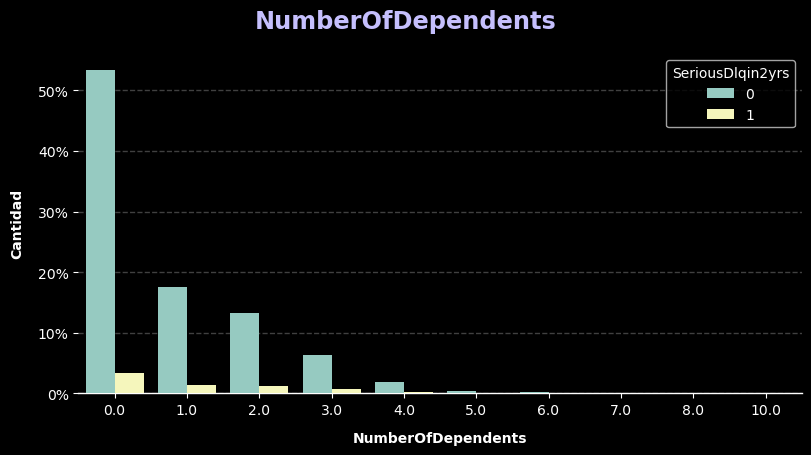

In [47]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"NumberOfDependents",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.countplot(
	x="NumberOfDependents",
	data=df_credit,
	hue="SeriousDlqin2yrs",
	stat="percent",
	zorder=9,
	ax=ax
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("NumberOfDependents", labelpad=10, fontdict=font_config)
ax.set_ylabel("Cantidad", labelpad=10, fontdict=font_config)
ax.grid(
	axis="y",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)

### Machine Learning Models

In [112]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, RandomizedSearchCV, RepeatedKFold, \
									StratifiedKFold, train_test_split, \
									cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [49]:
target = "SeriousDlqin2yrs"
discrete_features = [
	"age",
	"age_category",
	"NumberOfDependents",
	"NumberOfOpenCreditLinesAndLoans",
	"NumberRealEstateLoansOrLines",
	"NumberOfTime30-59DaysPastDueNotWorse",
	"NumberOfTime60-89DaysPastDueNotWorse",
	"NumberOfTimes90DaysLate"
]
continue_features = [
	"RevolvingUtilizationOfUnsecuredLines",
	"DebtRatio",
	"MonthlyIncome"
]

In [50]:
df_train, df_test = train_test_split(
	df_credit,
	test_size=.2,
	shuffle=True,
	stratify=df_credit[target],
	random_state=42
)

In [51]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

#### Preprocessing

##### Encoding

Hemose creado una variable categórica ordinal `age_category`. La codificamos para hacerla parte de nuestras features.

In [52]:
to_encode = [
	"Lactante",
	"Infancia temprana",
	"Niñez",
	"Adolescencia y juventud",
	"Adulto joven",
	"Adulto medio",
	"Adulto mayor"
]
ordinal_encoder = OrdinalEncoder(categories=[to_encode], dtype=int)
ordinal_encoder.set_output(transform="pandas")

OrdinalEncoder(categories=[['Lactante', 'Infancia temprana', 'Niñez',
                            'Adolescencia y juventud', 'Adulto joven',
                            'Adulto medio', 'Adulto mayor']],
               dtype=<class 'int'>)

**TRAIN**

In [53]:
encoded = ordinal_encoder.fit_transform(df_train[["age_category"]])
encoded.rename(columns={"age_category": "age_category_encoded"}, inplace=True)

df_train = pd.concat([df_train, encoded], axis=1)

In [54]:
df_train_scaled = pd.concat([df_train_scaled, encoded], axis=1)

**TEST**

In [55]:
encoded = ordinal_encoder.fit_transform(df_test[["age_category"]])
encoded.rename(columns={"age_category": "age_category_encoded"}, inplace=True)

df_test = pd.concat([df_test, encoded], axis=1)

In [56]:
df_test_scaled = pd.concat([df_test_scaled, encoded], axis=1)

##### StandardScaler

In [57]:
standard_scaler = StandardScaler()

**TRAIN**

In [58]:
scaled = standard_scaler.fit_transform(df_train_scaled[continue_features])
df_train_scaled[continue_features] = scaled

**TEST**

In [59]:
scaled = standard_scaler.fit_transform(df_test_scaled[continue_features])
df_test_scaled[continue_features] = scaled

In [60]:
df_train_scaled

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
8818                  0                              1.679359   51   
4520                  0                              1.806822   45   
337                   0                              0.562138   33   
12501                 0                             -0.792909   46   
8837                  0                             -0.650084   42   
...                 ...                                   ...  ...   
12390                 0                             -0.778475   44   
10382                 0                             -0.277923   69   
5907                  0                              0.666406   57   
2165                  0                              1.608165   31   
10443                 0                             -0.833587   65   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
8818                                      4  -0.158456       0.766156   
4520                                      0  -0.157095       0.027316   
337                                       0  -0.200379      -0.243923   
12501                                     0  -0.175278       0.611679   
8837                                      1  -0.200138      -0.285438   
...                                     ...        ...            ...   
12390                                     0  -0.187859       2.096959   
10382                                     0  -0.139407      -0.330475   
5907                                      0  -0.116848      -0.083330   
2165                                      0  -0.159313      -0.520073   
10443                                     0  -0.151011      -0.098805   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
8818                                10                        0   
4520                                 7                        0   
337                                  3                        0   
12501                                7                        0   
8837                                 3                        0   
...                                ...                      ...   
12390                               11                        0   
10382                                8                        0   
5907                                13                        0   
2165                                 3                        0   
10443                               10                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
8818                              3                                     0   
4520                              1                                     0   
337                               0                                     0   
12501                             1                                     0   
8837                              1                                     0   
...                             ...                                   ...   
12390                             3                                     0   
10382                             1                                     0   
5907                              1                                     0   
2165                              0                                     0   
10443                             2                                     0   

       NumberOfDependents  age_category  age_category_encoded  
8818                  4.0  Adulto medio                     5  
4520                  0.0  Adulto medio                     5  
337                   0.0  Adulto joven                     4  
12501                 0.0  Adulto medio                     5  
8837                  0.0  Adulto joven                     4  
...                   ...           ...                   ...  
12390                 2.0  Adulto joven                     4  
10382                 0.0  Adulto mayor        

#### Baseline: DecisionTreeClassifier

In [61]:
target = "SeriousDlqin2yrs"
discrete_features = [
	"age_category_encoded",
	"NumberOfDependents",
	"NumberOfOpenCreditLinesAndLoans",
	"NumberRealEstateLoansOrLines",
	"NumberOfTime30-59DaysPastDueNotWorse",
	"NumberOfTime60-89DaysPastDueNotWorse",
	"NumberOfTimes90DaysLate"
]
continue_features = [
	"RevolvingUtilizationOfUnsecuredLines",
	"DebtRatio",
	"MonthlyIncome"
]

In [62]:
discrete_features + continue_features

['age_category_encoded',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio',
 'MonthlyIncome']

In [63]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(df_train[discrete_features + continue_features], df_train[target])

DecisionTreeClassifier(random_state=42)

In [64]:
feature_importances = decision_tree.feature_importances_
fi = pd.DataFrame(
	feature_importances,
	index=discrete_features + continue_features,
	columns=["feature_importances"]
)

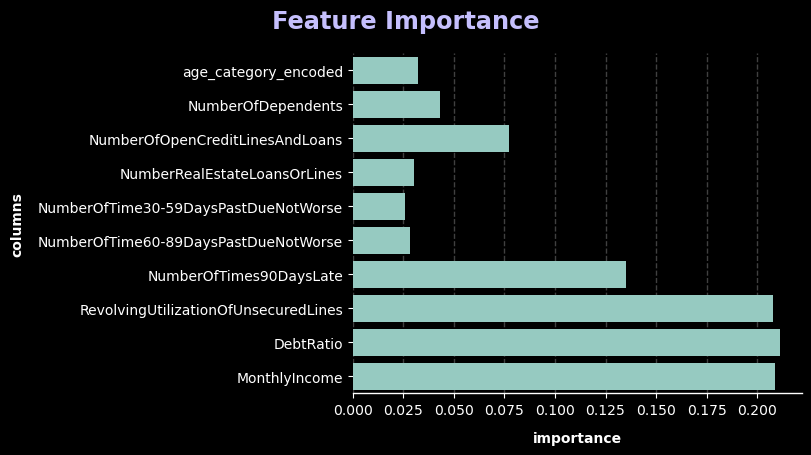

In [65]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"Feature Importance",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.barplot(
	data=fi,
	y=fi.index,
	x=fi.feature_importances,
	zorder=9,
	ax=ax
)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
ax.set_ylabel("columns", labelpad=10, fontdict=font_config)
ax.grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)
plt.show()

In [66]:
results = cross_validate(
	estimator=decision_tree,
	X=df_train[discrete_features + continue_features],
	y=df_train[target],
	cv=KFold(n_splits=5, shuffle=True, random_state=42),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = decision_tree.predict(df_test[discrete_features + continue_features])
report = classification_report(df_test[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.608

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2335
           1       0.27      0.30      0.29       173

    accuracy                           0.90      2508
   macro avg       0.61      0.62      0.61      2508
weighted avg       0.90      0.90      0.90      2508



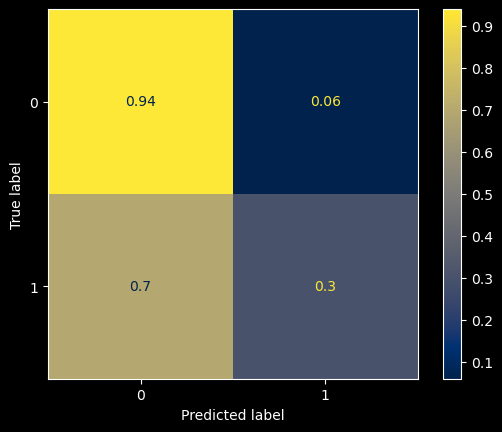

In [67]:
ConfusionMatrixDisplay.from_predictions(
	df_test[target],
	predictions,
	normalize="true",
	cmap="cividis"
);

##### RandomizedSearchCV

In [68]:
from scipy.stats import loguniform, uniform, randint

In [95]:
params = {
	#"criterion": ["gini", "entropy", "log_loss"],
	#"splitter": ["best", "random"],
	"max_depth": [None] + list(range(2, 20)),
	"min_samples_split": randint(2, 20),
	"min_samples_leaf": randint(4, 20),
	"min_weight_fraction_leaf": uniform(.0, .05),
	"max_features": ["sqrt", "log2", None, .6, .7, .8],
	"max_leaf_nodes": randint(10, 100),
	"min_impurity_decrease": loguniform(1e-5, 1e-1),
	"class_weight": [
		None,
		"balanced",
		{0: 1, 1: 3},
		{0: 1, 1: 5}
	],
	"ccp_alpha": loguniform(1e-5, 1e-1)
}

randomized_search = RandomizedSearchCV(
	param_distributions=params,
	estimator=DecisionTreeClassifier(random_state=42),
	n_iter=100,
	cv=KFold(n_splits=5, shuffle=True, random_state=42),
	scoring="balanced_accuracy",
	n_jobs=-1,
	random_state=99
)
randomized_search.fit(
	df_train[discrete_features + continue_features],
	df_train[target]
)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0b32f87d10>,
                                        'class_weight': [None, 'balanced',
                                                         {0: 1, 1: 3},
                                                         {0: 1, 1: 5}],
                                        'max_depth': [None, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13...
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0b32f851f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0b3a4875f0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0b3a0c3320>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0b3a285850>},
                   random_state=99, scoring='balanced_accuracy')

Análisis de los mejores hiperparámetros de `DecisionTreeClassifier`

In [96]:
pd.DataFrame(randomized_search.cv_results_).sort_values(
	by="rank_test_score",
	ascending=True
).loc[:, :"mean_test_score"].head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
78       0.025019      0.001177         0.003083        0.000396   
44       0.021540      0.002820         0.003228        0.000328   
99       0.012428      0.001467         0.002088        0.000376   
0        0.021142      0.005582         0.004136        0.000740   
34       0.014081      0.000790         0.002999        0.000232   

    param_ccp_alpha param_class_weight param_max_depth param_max_features  \
78         0.001973           balanced              11                0.8   
44         0.006189           balanced               4               None   
99         0.000463           balanced              12                0.6   
0          0.004888           balanced               9               log2   
34         0.019946           balanced              14               log2   

    param_max_leaf_nodes  param_min_impurity_decrease  param_min_samples_leaf  \
78                    88                     0.001683                      17   
44                    24                     0.000024                      19   
99                    56                     0.010665                      10   
0                     92                     0.006368                       8   
34                    34                     0.000489                      16   

    param_min_samples_split  param_min_weight_fraction_leaf  \
78                        4                        0.000694   
44                       11                        0.040727   
99                       18                        0.006743   
0                         3                        0.048867   
34                        2                        0.005784   

                                               params  split0_test_score  \
78  {'ccp_alpha': 0.0019730953934627015, 'class_we...           0.751604   
44  {'ccp_alpha': 0.006188864001500256, 'class_wei...           0.748329   
99  {'ccp_alpha': 0.0004626491514600509, 'class_we...           0.751604   
0   {'ccp_alpha': 0.004887809087802787, 'class_wei...           0.736029   
34  {'ccp_alpha': 0.019945639831014935, 'class_wei...           0.736029   

    split1_test_score  split2_test_score  split3_test_score  \
78           0.775670           0.752631           0.748724   
44           0.773603           0.747000           0.720654   
99           0.774319           0.739136           0.723005   
0            0.773871           0.748062           0.721189   
34           0.773871           0.748062           0.721189   

    split4_test_score  mean_test_score  
78           0.800863         0.765898  
44           0.770026         0.751922  
99           0.762982         0.750209  
0            0.770026         0.749835  
34           0.770026         0.749835

Mejores hiperparámetros:

In [97]:
best_params = randomized_search.best_params_
print(best_params)

{'ccp_alpha': np.float64(0.0019730953934627015), 'class_weight': 'balanced', 'max_depth': 11, 'max_features': 0.8, 'max_leaf_nodes': 88, 'min_impurity_decrease': np.float64(0.0016830091380203836), 'min_samples_leaf': 17, 'min_samples_split': 4, 'min_weight_fraction_leaf': np.float64(0.0006940884188217978)}


In [98]:
decision_tree = DecisionTreeClassifier(**best_params, random_state=42)
decision_tree.fit(df_train[discrete_features + continue_features], df_train[target])

DecisionTreeClassifier(ccp_alpha=np.float64(0.0019730953934627015),
                       class_weight='balanced', max_depth=11, max_features=0.8,
                       max_leaf_nodes=88,
                       min_impurity_decrease=np.float64(0.0016830091380203836),
                       min_samples_leaf=17, min_samples_split=4,
                       min_weight_fraction_leaf=np.float64(0.0006940884188217978),
                       random_state=42)

In [99]:
feature_importances = decision_tree.feature_importances_
fi = pd.DataFrame(
	feature_importances,
	index=discrete_features + continue_features,
	columns=["feature_importances"]
)

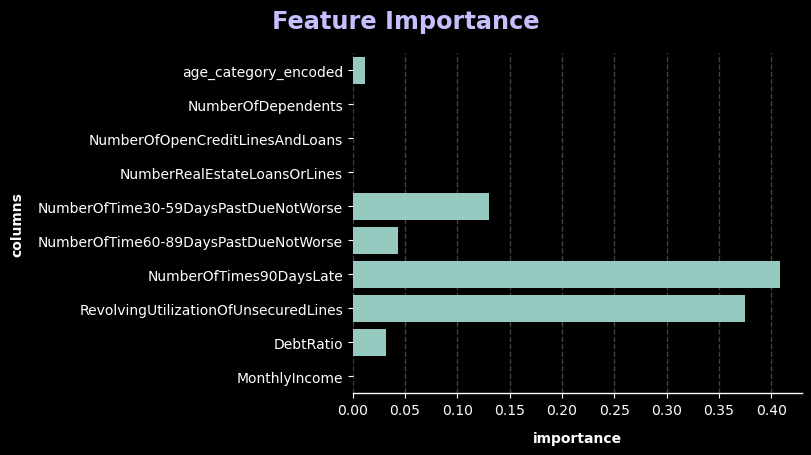

In [100]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"Feature Importance",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.barplot(
	data=fi,
	y=fi.index,
	x=fi.feature_importances,
	zorder=9,
	ax=ax
)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
ax.set_ylabel("columns", labelpad=10, fontdict=font_config)
ax.grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)
plt.show()

In [101]:
results = cross_validate(
	estimator=decision_tree,
	X=df_train[discrete_features + continue_features],
	y=df_train[target],
	cv=KFold(n_splits=5, shuffle=True, random_state=42),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = decision_tree.predict(df_test[discrete_features + continue_features])
report = classification_report(df_test[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.766

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2335
           1       0.18      0.80      0.29       173

    accuracy                           0.73      2508
   macro avg       0.58      0.76      0.56      2508
weighted avg       0.92      0.73      0.80      2508



A través de la búsqueda de hiperparámetros hemos logrado mejorar nuestra métrica más de un 15%.

---

**Métricas pre fine-tunning**:
```python
TRAIN
---------------
RECALL: 0.608

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2335
           1       0.27      0.30      0.29       173

    accuracy                           0.90      2508
   macro avg       0.61      0.62      0.61      2508
weighted avg       0.90      0.90      0.90      2508
```


**Métricas post fine-tunning**:
```python
TRAIN
---------------
RECALL: 0.766

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2335
           1       0.18      0.80      0.29       173

    accuracy                           0.73      2508
   macro avg       0.58      0.76      0.56      2508
weighted avg       0.92      0.73      0.80      2508
```

Aunque podemos seguir explorando mejoras en los hiperparámetros, finalizamos nuestra búsqueda y damos paso a otro modelo.

#### KNeighborsClassifier

In [257]:
knn_classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_classifier.fit(
	df_train_scaled[discrete_features + continue_features],
	df_train_scaled[target]
)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [259]:
results = cross_validate(
	estimator=knn_classifier,
	X=df_train_scaled[discrete_features + continue_features],
	y=df_train_scaled[target],
	cv=StratifiedKFold(n_splits=8, shuffle=True, random_state=42),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = knn_classifier.predict(
	df_test_scaled[discrete_features + continue_features]
)
report = classification_report(df_test_scaled[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.57

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2335
           1       0.46      0.19      0.27       173

    accuracy                           0.93      2508
   macro avg       0.70      0.59      0.62      2508
weighted avg       0.91      0.93      0.91      2508



##### RandomizedSearchCV

In [260]:
params = {
	"n_neighbors": randint(3, 20),
	"weights": ["distance", "uniform"],
	"algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
	"leaf_size": randint(10, 60),
	"p": [1, 2],
}

randomized_search = RandomizedSearchCV(
	param_distributions=params,
	estimator=KNeighborsClassifier(n_jobs=-1),
	n_iter=100,
	cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
	scoring="balanced_accuracy",
	n_jobs=-1,
	random_state=99,
)
randomized_search.fit(
	df_train_scaled[discrete_features + continue_features],
	df_train_scaled[target]
)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(n_jobs=-1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0b20115a60>,
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0ac31fb8c0>,
                                        'p': [1, 2],
                                        'weights': ['distance', 'uniform']},
                   random_state=99, scoring='balanced_accuracy')

Análisis de los mejores hiperparámetros de `KNeighborsClassifier`.

In [261]:
pd.DataFrame(randomized_search.cv_results_).sort_values(
	by="rank_test_score",
	ascending=True
).loc[:, :"mean_test_score"].head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
54       0.016579      0.005951         0.154817        0.023850   
40       0.026420      0.007210         0.300351        0.068704   
90       0.033311      0.019167         0.127386        0.040111   
91       0.052146      0.018296         0.160153        0.016266   
25       0.031693      0.003164         0.108126        0.022855   

   param_algorithm  param_leaf_size  param_n_neighbors  param_p param_weights  \
54         kd_tree               37                  4        1      distance   
40       ball_tree               40                  4        1      distance   
90            auto               18                  4        1      distance   
91            auto               57                  4        1      distance   
25         kd_tree               51                  3        1      distance   

                                               params  split0_test_score  \
54  {'algorithm': 'kd_tree', 'leaf_size': 37, 'n_n...           0.591813   
40  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n...           0.591813   
90  {'algorithm': 'auto', 'leaf_size': 18, 'n_neig...           0.591813   
91  {'algorithm': 'auto', 'leaf_size': 57, 'n_neig...           0.591813   
25  {'algorithm': 'kd_tree', 'leaf_size': 51, 'n_n...           0.591278   

    split1_test_score  split2_test_score  split3_test_score  \
54           0.547264           0.574912           0.585607   
40           0.547264           0.574912           0.585607   
90           0.547264           0.574912           0.585607   
91           0.547264           0.574912           0.585607   
25           0.551423           0.575858           0.575083   

    split4_test_score  mean_test_score  
54           0.576386         0.575196  
40           0.576386         0.575196  
90           0.576386         0.575196  
91           0.576386         0.575196  
25           0.574511         0.573631

Mejores hiperparámetros

In [262]:
best_params = randomized_search.best_params_
print(best_params)

{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [263]:
knn_classifier = KNeighborsClassifier(**best_params, n_jobs=-1)
knn_classifier.fit(
	df_train_scaled[discrete_features + continue_features],
	df_train_scaled[target]
)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, n_jobs=-1,
                     n_neighbors=4, p=1, weights='distance')

In [264]:
results = cross_validate(
	estimator=knn_classifier,
	X=df_train_scaled[discrete_features + continue_features],
	y=df_train_scaled[target],
	cv=RepeatedKFold(n_splits=5, n_repeats=6, random_state=42),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = knn_classifier.predict(
	df_test_scaled[discrete_features + continue_features]
)
report = classification_report(df_test_scaled[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.568

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2335
           1       0.41      0.18      0.25       173

    accuracy                           0.93      2508
   macro avg       0.67      0.58      0.60      2508
weighted avg       0.90      0.93      0.91      2508



Revisamos nuestras métricas del `KNeighborsClassifier`

---

> **Métricas de BASELINE**
> ```python
>
> TRAIN
> ---------------
> RECALL: 0.762
>
> TEST
> -----------------------------------------------------
>               precision    recall  f1-score   support
>
>            0       0.98      0.82      0.89      2335
>            1       0.23      0.74      0.35       173
>
>     accuracy                           0.81      2508
>    macro avg       0.60      0.78      0.62      2508
> weighted avg       0.93      0.81      0.85      2508
> ```

**Métricas pre fine-tunning `KNeighborsClassifier`**:
```python
TRAIN
---------------
RECALL: 0.57

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2335
           1       0.46      0.19      0.27       173

    accuracy                           0.93      2508
   macro avg       0.70      0.59      0.62      2508
weighted avg       0.91      0.93      0.91      2508
```

**Métricas post fine-tunning `KNeighborsClassifier`**:
```python
TRAIN
---------------
RECALL: 0.568

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2335
           1       0.41      0.18      0.25       173

    accuracy                           0.93      2508
   macro avg       0.67      0.58      0.60      2508
weighted avg       0.90      0.93      0.91      2508
```

Podemos observar que nuestro modelo baseline tiene un rendimiento mucho mejor al momento de identificar nuestro target.

#### LGBMClassifier

In [83]:
from lightgbm import LGBMClassifier

In [265]:
light_gbm = LGBMClassifier(objective="binary", n_jobs=-1, random_state=42)
light_gbm.fit(
	df_train[discrete_features + continue_features],
	df_train[target]
)

[LightGBM] [Info] Number of positive: 691, number of negative: 9338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 10029, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068900 -> initscore=-2.603708
[LightGBM] [Info] Start training from score -2.603708


LGBMClassifier(n_jobs=-1, objective='binary', random_state=42)

In [266]:
feature_importances = light_gbm.feature_importances_
fi = pd.DataFrame(
	feature_importances,
	index=discrete_features + continue_features,
	columns=["feature_importances"]
)

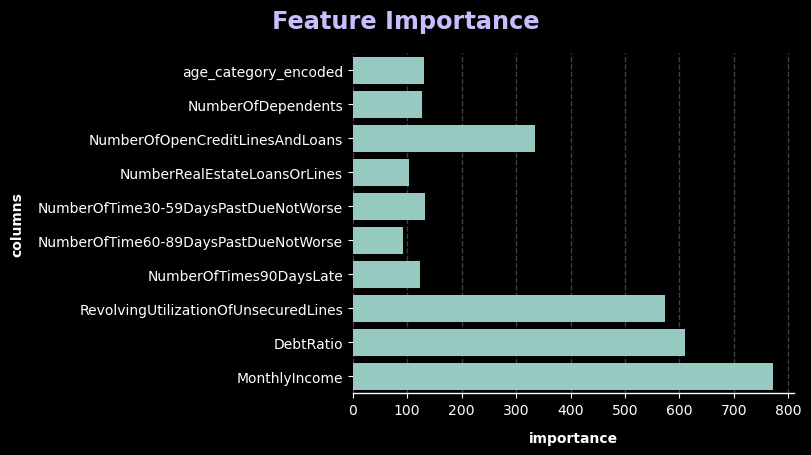

In [267]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"Feature Importance",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.barplot(
	data=fi,
	y=fi.index,
	x=fi.feature_importances,
	zorder=9,
	ax=ax
)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
ax.set_ylabel("columns", labelpad=10, fontdict=font_config)
ax.grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)
plt.show()

In [268]:
results = cross_validate(
	estimator=light_gbm,
	X=df_train[discrete_features + continue_features],
	y=df_train[target],
	cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = light_gbm.predict(
	df_test[discrete_features + continue_features]
)
report = classification_report(df_test[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.61

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2335
           1       0.62      0.29      0.40       173

    accuracy                           0.94      2508
   macro avg       0.79      0.64      0.68      2508
weighted avg       0.93      0.94      0.93      2508



##### RandomizedSearchCV

In [551]:
params = {
	"colsample_bytree": uniform(.6, .3),
	"min_child_samples": randint(2, 15),
	"n_estimators": randint(50, 650),
	"num_leaves": randint(10, 200),
	"learning_rate": loguniform(1e-3, 1),
	"subsample": uniform(.4, .3),
	"reg_alpha": loguniform(1e-4, 2),
	"reg_lambda": loguniform(1e-4, 2),
}

randomized_search = RandomizedSearchCV(
	param_distributions=params,
	estimator=LGBMClassifier(
		boost_from_average=True,
		is_unbalance=True,
		objective="binary",
		n_jobs=-1,
		verbosity=0,
		random_state=42
	),
	n_iter=100,
	cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
	scoring="balanced_accuracy",
	n_jobs=-1,
	random_state=42
)

randomized_search.fit(
	df_train[discrete_features + continue_features],
	df_train[target]
)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(boost_from_average=True,
                                            is_unbalance=True, n_jobs=-1,
                                            objective='binary', random_state=42,
                                            verbosity=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0ac2436150>,
                                        'learn...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f0ae43240e0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0ae4c76a20>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0ae6ddf530>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f0ae434e2d0>},
                   random_state=42, scoring='balanced_accuracy')

Análisis de los mejores hiperparámetros de `LGBMClassifier`.

In [552]:
pd.DataFrame(randomized_search.cv_results_).sort_values(
	by="rank_test_score",
	ascending=True
).loc[:, :"mean_test_score"].head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
38      11.422869      0.814746         0.029315        0.005298   
13      12.814322      1.397136         0.039478        0.008336   
37      13.712798      0.473975         0.022308        0.004620   
76      11.926433      0.182948         0.032307        0.008692   
94       2.115120      0.264440         0.015560        0.005077   

    param_colsample_bytree  param_learning_rate  param_min_child_samples  \
38                0.765846             0.007754                       11   
13                0.670795             0.005864                       12   
37                0.707594             0.005787                       11   
76                0.749450             0.026831                        4   
94                0.633612             0.015616                       13   

    param_n_estimators  param_num_leaves  param_reg_alpha  param_reg_lambda  \
38                 457                22         0.000224          0.000105   
13                 442                24         0.000300          0.007755   
37                 435                26         0.446842          0.000387   
76                 355                21         0.324563          1.456412   
94                 124                13         0.000105          1.562403   

    param_subsample                                             params  \
38         0.588368  {'colsample_bytree': 0.7658459930723723, 'lear...   
13         0.460516  {'colsample_bytree': 0.6707954759246867, 'lear...   
37         0.612673  {'colsample_bytree': 0.7075940343888492, 'lear...   
76         0.426522  {'colsample_bytree': 0.7494495559937678, 'lear...   
94         0.547225  {'colsample_bytree': 0.6336116706504157, 'lear...   

    split0_test_score  split1_test_score  split2_test_score  \
38           0.765366           0.746571           0.795996   
13           0.748444           0.746571           0.795852   
37           0.751389           0.743875           0.787124   
76           0.744658           0.735003           0.799045   
94           0.737823           0.739181           0.793567   

    split3_test_score  split4_test_score  mean_test_score  
38           0.788937           0.756488         0.770671  
13           0.778566           0.755133         0.764913  
37           0.770988           0.750833         0.760842  
76           0.778870           0.735269         0.758569  
94           0.775389           0.736481         0.756488

Mejores hiperparámetrosm

In [553]:
best_params = randomized_search.best_params_
print(best_params)

{'colsample_bytree': np.float64(0.7658459930723723), 'learning_rate': np.float64(0.007754082741871918), 'min_child_samples': 11, 'n_estimators': 457, 'num_leaves': 22, 'reg_alpha': np.float64(0.00022435668651918792), 'reg_lambda': np.float64(0.00010526894011209383), 'subsample': np.float64(0.5883683244845909)}


In [554]:
light_gbm = LGBMClassifier(
	**best_params,
	boost_from_average=True,
	is_unbalance=True,
	objective="binary",
	n_jobs=-1,
	random_state=42
)
light_gbm.fit(
	df_train[discrete_features + continue_features],
	df_train[target]
)

[LightGBM] [Info] Number of positive: 691, number of negative: 9338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 10029, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068900 -> initscore=-2.603708
[LightGBM] [Info] Start training from score -2.603708


LGBMClassifier(boost_from_average=True,
               colsample_bytree=np.float64(0.7658459930723723),
               is_unbalance=True,
               learning_rate=np.float64(0.007754082741871918),
               min_child_samples=11, n_estimators=457, n_jobs=-1, num_leaves=22,
               objective='binary', random_state=42,
               reg_alpha=np.float64(0.00022435668651918792),
               reg_lambda=np.float64(0.00010526894011209383),
               subsample=np.float64(0.5883683244845909))

In [555]:
feature_importances = light_gbm.feature_importances_
fi = pd.DataFrame(
	feature_importances,
	index=discrete_features + continue_features,
	columns=["feature_importances"]
)

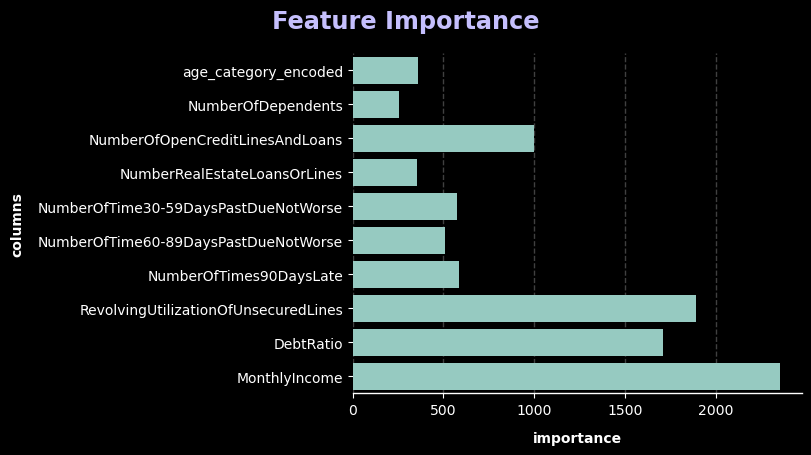

In [556]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"Feature Importance",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.barplot(
	data=fi,
	y=fi.index,
	x=fi.feature_importances,
	zorder=9,
	ax=ax
)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
ax.set_ylabel("columns", labelpad=10, fontdict=font_config)
ax.grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)
plt.show()

In [557]:
results = cross_validate(
	estimator=light_gbm,
	X=df_train[discrete_features + continue_features],
	y=df_train[target],
	cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=99),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = light_gbm.predict(
	df_test[discrete_features + continue_features]
)
report = classification_report(df_test[target], predictions)
print(report)


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


Revisamos las métricas de `LGBMClassifier`.

---
> **Métricas de BASELINE**
> ```python
>
> TRAIN
> ---------------
> RECALL: 0.766
>
> TEST
> -----------------------------------------------------
>               precision    recall  f1-score   support
>
>            0       0.98      0.72      0.83      2335
>            1       0.18      0.80      0.29       173
>
>     accuracy                           0.73      2508
>    macro avg       0.58      0.76      0.56      2508
> weighted avg       0.92      0.73      0.80      2508
> ```


**Métricas pre fine-tunning `LGBMClassifier`**:

```python
TRAIN
---------------
RECALL: 0.61

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2335
           1       0.62      0.29      0.40       173

    accuracy                           0.94      2508
   macro avg       0.79      0.64      0.68      2508
weighted avg       0.93      0.94      0.93      2508
```

**Métricas post fine-tunning `LGBMClassifier`**:

```python
--------------
RECALL: 0.767

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2335
           1       0.26      0.74      0.38       173

    accuracy                           0.84      2508
   macro avg       0.62      0.79      0.64      2508
weighted avg       0.93      0.84      0.87      2508
```

Con este modelo obtuvimos un rendimiento cercano a nuestro baseline, es levemente superior. Tal vez, con una mejor búsqueda de hiperparámetros entre estos modelos podemos terminar de optar por uno u otro. La diferencia entre los modelos se puede reducir e incluso, en algunas iteracciones, `LightGBM` tuvo un mejor rendimiento.

Sí no hay una clara diferencia en nuestra métrica, optaría por el modelo que sea más simple de explicar.

#### Resampling

In [558]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

##### **Oversampling** with SMOTE

In [595]:
smote = SMOTE(k_neighbors=5, random_state=42)
x_smote, y_smote = smote.fit_resample(
	X=df_train_scaled[discrete_features + continue_features],
	y=df_train_scaled[target]
)

In [566]:
print("X shape:", x_smote.shape)
print("Y shape:", y_smote.shape)

X shape: (18676, 10)
Y shape: (18676,)


In [567]:
y_smote.value_counts()

SeriousDlqin2yrs
0    9338
1    9338
Name: count, dtype: int64

In [596]:
light_gbm = LGBMClassifier(
	colsample_bytree=np.float64(0.7658459930723723),
	learning_rate=np.float64(0.007754082741871918),
	min_child_samples=11,
	n_estimators=457,
	num_leaves=22,
	reg_alpha=np.float64(0.00022435668651918792),
	reg_lambda=np.float64(0.00010526894011209383),
	subsample=np.float64(0.5883683244845909),
	boost_from_average=True,
	is_unbalance=True,
	objective="binary",
	n_jobs=-1,
	random_state=42
)
light_gbm.fit(x_smote, y_smote)

[LightGBM] [Info] Number of positive: 9338, number of negative: 9338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 18676, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(boost_from_average=True,
               colsample_bytree=np.float64(0.7658459930723723),
               is_unbalance=True,
               learning_rate=np.float64(0.007754082741871918),
               min_child_samples=11, n_estimators=457, n_jobs=-1, num_leaves=22,
               objective='binary', random_state=42,
               reg_alpha=np.float64(0.00022435668651918792),
               reg_lambda=np.float64(0.00010526894011209383),
               subsample=np.float64(0.5883683244845909))

In [597]:
feature_importances = light_gbm.feature_importances_
fi = pd.DataFrame(
	feature_importances,
	index=discrete_features + continue_features,
	columns=["feature_importances"]
)

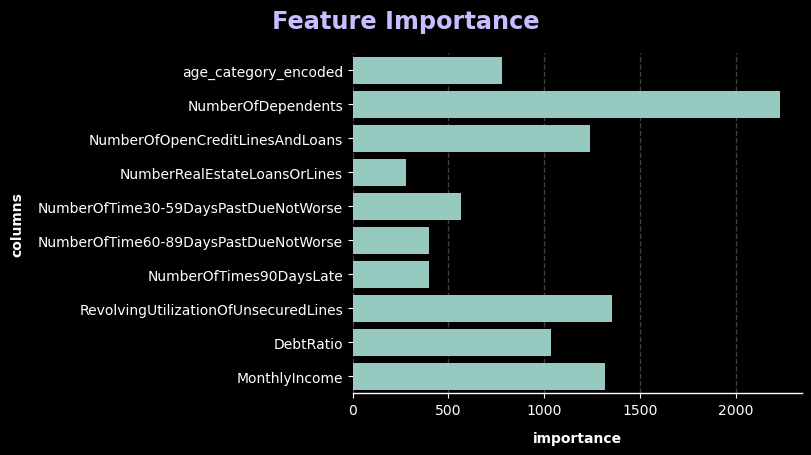

In [598]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(
	"Feature Importance",
	color="#C5BFFD",
	fontproperties=font_config,
	y=1.10
)
sns.barplot(
	data=fi,
	y=fi.index,
	x=fi.feature_importances,
	zorder=9,
	ax=ax
)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
ax.set_ylabel("columns", labelpad=10, fontdict=font_config)
ax.grid(
	axis="x",
	alpha=1,
	color="#404040",
	linestyle="dashed",
	linewidth=1
)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_linewidth(1)
plt.show()

In [600]:
results = cross_validate(
	estimator=light_gbm,
	X=x_smote[discrete_features + continue_features],
	y=y_smote,
	cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=99),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = light_gbm.predict(
	df_test_scaled[discrete_features + continue_features]
)
report = classification_report(df_test_scaled[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.836

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2335
           1       0.20      0.72      0.31       173

    accuracy                           0.78      2508
   macro avg       0.59      0.75      0.59      2508
weighted avg       0.92      0.78      0.83      2508



Luego de haber realizado un oversampling utilizando la técnica de `SMOTE` podemos concluir que la técnica aporta valor, pero queda por detrás de la optimización de hiperparámetros. Nuestro baseline con una búsqueda de hiperparámetros standard logro una mejora significativa respecto al oversampling.

##### **Undersampling** with RandomUnderSampler

In [601]:
random_under_sampler = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = random_under_sampler.fit_resample(
	X=df_train[discrete_features + continue_features],
	y=df_train[target]
)

In [590]:
print("X shape:", x_rus.shape)
print("Y shape:", y_rus.shape)

X shape: (1382, 10)
Y shape: (1382,)


In [591]:
y_rus.value_counts()

SeriousDlqin2yrs
0    691
1    691
Name: count, dtype: int64

In [603]:
light_gbm = LGBMClassifier(
	colsample_bytree=np.float64(0.7658459930723723),
	learning_rate=np.float64(0.007754082741871918),
	min_child_samples=11,
	n_estimators=457,
	num_leaves=22,
	reg_alpha=np.float64(0.00022435668651918792),
	reg_lambda=np.float64(0.00010526894011209383),
	subsample=np.float64(0.5883683244845909),
	boost_from_average=True,
	is_unbalance=True,
	objective="binary",
	n_jobs=-1,
	random_state=42
)
light_gbm.fit(x_rus, y_rus)

[LightGBM] [Info] Number of positive: 691, number of negative: 691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 1382, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(boost_from_average=True,
               colsample_bytree=np.float64(0.7658459930723723),
               is_unbalance=True,
               learning_rate=np.float64(0.007754082741871918),
               min_child_samples=11, n_estimators=457, n_jobs=-1, num_leaves=22,
               objective='binary', random_state=42,
               reg_alpha=np.float64(0.00022435668651918792),
               reg_lambda=np.float64(0.00010526894011209383),
               subsample=np.float64(0.5883683244845909))

In [604]:
results = cross_validate(
	estimator=light_gbm,
	X=x_rus,
	y=y_rus,
	cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=99),
	scoring=["balanced_accuracy"],
	n_jobs=-1
)

print("TRAIN")
print("-"*15)
recall = np.mean(results["test_balanced_accuracy"])
print("RECALL:", round(recall, 3))

print()

print("TEST")
print("-"*53)
predictions = light_gbm.predict(
	df_test[discrete_features + continue_features]
)
report = classification_report(df_test[target], predictions)
print(report)

TRAIN
---------------
RECALL: 0.78

TEST
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      2335
           1       0.21      0.77      0.33       173

    accuracy                           0.78      2508
   macro avg       0.59      0.78      0.60      2508
weighted avg       0.93      0.78      0.83      2508



### Conclusión

> **OVERSAMPLING: SMOTE**
>
> ```python
> TRAIN
> ---------------
> RECALL: 0.836
>
> TEST
> -----------------------------------------------------
>               precision    recall  f1-score   support
>            0       0.97      0.79      0.87      2335
>            1       0.20      0.72      0.31       173
>
>     accuracy                           0.78      2508
>    macro avg       0.59      0.75      0.59      2508
> weighted avg       0.92      0.78      0.83      2508
> ```

> **UNDERSAMPLING: RandomUnderSampler**
>
> ```python
> TRAIN
> ---------------
> RECALL: 0.78
>
> TEST
> -----------------------------------------------------
>               precision    recall  f1-score   support
>
>            0       0.98      0.78      0.87      2335
>            1       0.21      0.77      0.33       173
>
>     accuracy                           0.78      2508
>    macro avg       0.59      0.78      0.60      2508
> weighted avg       0.93      0.78      0.83      2508
> ```

> **BEST MODEL: LGBMClassifier**
>
> ```python
> TRAIN
> ---------------
> RECALL: 0.758
>
> TEST
> -----------------------------------------------------
>               precision    recall  f1-score   support
>
>            0       0.98      0.77      0.86      2335
>            1       0.20      0.78      0.32       173
>
>     accuracy                           0.77      2508
>    macro avg       0.59      0.78      0.59      2508
> weighted avg       0.93      0.77      0.83      2508
> ```

Luego de analizar los datos podemos entender que tanto el `undersampling` como el `oversampling` no logra una mejora sustancial respecto a `LGBMClassifier`.